# Brain Tumor Classification

Niyati Prabhu np23634, Monique Tran mkt973


## Library Imports 

In [8]:
import matplotlib.pyplot as plt  
import numpy as np  
import random
import os
import cv2
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim  
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms  
from torchvision.datasets import ImageFolder

## Data Preprocessing

Let's ensure that our data can be properly fed into the model. 

First, we will resize the images to 224x224 so standardize all the input images. This value was chosen because it's common amongst models pretrained on the ImageNet dataset and is a popular value.

Then, we will convert the raw image into a tensor.

Last, we will normalize the tensors with the mean and std (also values chosen from ImageNet – these values were calculated from millions of images). This step will assist the model in learning by forcing all the data to center at 0 and have a similar scale so that features with larger magnitudes won't dominate the learning process.

In [10]:
resize_transform = transforms.Resize((224, 224))
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Now, we will load in our data and transform it.

In [7]:
train_dataset = ImageFolder("d1/Training", transform=transforms.Compose([resize_transform, to_tensor_transform, normalize_transform]))

test_dataset = ImageFolder("d1/Testing", transform=transforms.Compose([resize_transform, to_tensor_transform, normalize_transform]))

Let's take a look at what some MRIs from each class looks like.

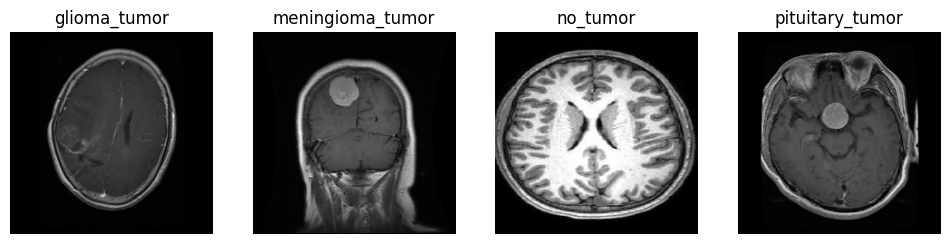

In [8]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

image_size = 224

plt.figure(figsize=(12, 6))

for i, label in enumerate(labels):
    folderPath = os.path.join('./d1/Training', label)
    img_files = os.listdir(folderPath)
   
    # find a random image for each class
    random_img = random.choice(img_files)
    img_path = os.path.join(folderPath, random_img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (image_size, image_size))

    plt.subplot(1, len(labels), i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')

plt.show()

Let's also see what the distribution across each class looks like.

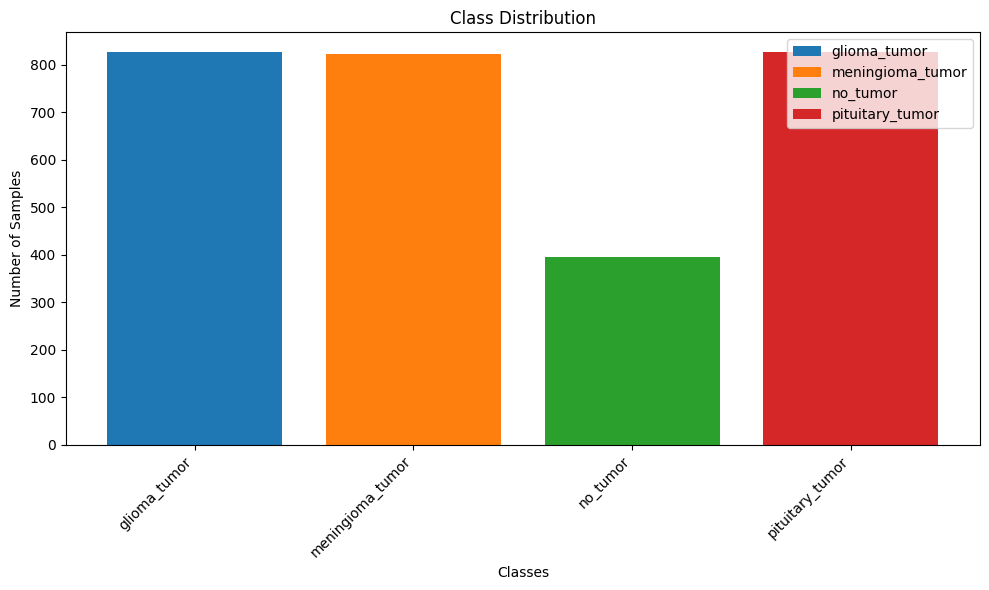

In [9]:
classes = train_dataset.classes
class_counts = [0] * len(classes)

# count samples in each class
for _, label in train_dataset:
    class_counts[label] += 1

# make each bar different colors
colors = plt.cm.tab10(np.arange(len(classes)))

plt.figure(figsize=(10, 6))
bars = plt.bar(np.arange(len(classes)), class_counts, tick_label=classes, color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# legend
plt.legend(bars, classes, loc='upper right')

plt.show()

We can see that the no tumor class has half the number of samples as the other 3 classes, which seem to be evenly distributed at about 800 samples each.

Now, let us split the training set into the training and validation sets.

In [10]:
# let's use 15% of the training set to validate against
validation_ratio = 0.15

# find sizes of training and validation sets
train_size = int((1 - validation_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size

# split randomly
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Let's use dataloaders to load and batch data later.

In [11]:
batch_size = 32
trainset_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valset_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
testset_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training and Test Functions

Here is a helper method to plot values.

In [95]:
def plot_metrics(metric, x, y, subplot_index):
    plt.subplot(2, 2, subplot_index)
    plt.plot(x, label='Train')
    plt.plot(y, label='Validation')
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()

Here is a helper method to calculate F1, precision, recall, and average loss scores.

In [96]:
def get_metrics(labels, preds, loss, dataloader):
    f1 = f1_score(labels, preds, average='weighted', zero_division=1)
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted', zero_division=1)
    epoch_loss = loss / len(dataloader)

    return f1, precision, recall, epoch_loss

Here is a helper method to perform validation for 1 epoch.

In [97]:
def validation_one_epoch(model, criterion):
    model.eval()
    # this epoch's validation loss
    cur_val_loss = 0
    validation_labels, validation_predictions = [], []
    for inputs, labels in valset_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        cur_val_loss += loss.item()

        # save actual labels
        validation_labels += labels.numpy().tolist()
        # save predicted labels
        predicted = torch.argmax(outputs, dim=1)
        validation_predictions += predicted.numpy().tolist()

    return validation_predictions, validation_labels, cur_val_loss

Here is a helper method to perform training for 1 epoch.

In [98]:
def training_one_epoch(optimizer, model, criterion):
    # this epoch's training loss
    cur_train_loss = 0
    training_labels, training_predictions = [], []

    # training
    for inputs, labels in trainset_dataloader:
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step()

        # save loss
        cur_train_loss += loss.item() 
        # save actual labels
        training_labels += [label.item() for label in labels]
        # save predicted labels
        predicted_train = torch.max(outputs, 1)[1]
        training_predictions += predicted_train.tolist()

    return training_predictions, training_labels, cur_train_loss

This will perform validation and training for $x$ epochs and save the F1, precision, recall, and average loss scores to plot at the end.

In [99]:
def train(model, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = epochs

    # store this information for later to calculate metrics
    training_losses, validation_losses = [], []
    training_f1s, validation_f1s = [], []
    training_precisions, validation_precisions = [], []
    training_recalls, validation_recalls = [], []

    for epoch in range(epochs):
        # training
        training_predictions, training_labels, cur_train_loss = training_one_epoch(optimizer, model, criterion)

        # validation
        validation_predictions, validation_labels, cur_val_loss = validation_one_epoch(model, criterion)

        # find training scores
        train_f1, train_precision, train_recall, train_epoch_loss = get_metrics(training_labels, training_predictions, cur_train_loss, trainset_dataloader)
        # save training scores
        training_losses.append(train_epoch_loss)
        training_precisions.append(train_precision)
        training_recalls.append(train_recall)
        training_f1s.append(train_f1)

        # find validation scores
        val_f1, val_precision, val_recall, val_epoch_loss = get_metrics(validation_labels, validation_predictions, cur_val_loss, valset_dataloader)
        # save validation scores
        validation_losses.append(val_epoch_loss)
        validation_precisions.append(val_precision)
        validation_recalls.append(val_recall)
        validation_f1s.append(val_f1)
        
        # print info
        if (epoch + 1) % 5 == 0: 
            print(f"Epoch [{epoch+1}/{epochs}], "
                f"T Loss: {train_epoch_loss:.3f}, V Loss: {val_epoch_loss:.3f}, "
                f"T Precision: {train_precision:.3f}, V Precision: {val_precision:.3f}, "
                f"T Recall: {train_recall:.3f}, V Recall: {val_recall:.3f}, "
                f"T F1: {train_f1:.3f}, V F1: {val_f1:.3f}")
        
    # plot all metrics
    plt.figure(figsize=(12, 8))
    plot_metrics("Loss", training_losses, validation_losses, 1)
    plot_metrics("Precision", training_precisions, validation_precisions, 2)
    plot_metrics("Recall", training_recalls, validation_recalls, 3)
    plot_metrics("F1 Score", training_f1s, validation_f1s, 4)
    plt.tight_layout()
    plt.show()

This will evaluate the model on the test set and print all metrics.

In [100]:
def evaluate_on_test(model):
    model.eval()

    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in testset_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)

            actual_labels += labels.cpu().numpy().tolist()
            predictions += predicted.cpu().numpy().tolist()

    print("Classification report on test set:")
    print(classification_report(actual_labels, predictions))

## Experiment 1: Building and Testing Models

All models will be derivations of model 1. Model 1's architecture is listed out, and every subsequent model will have the derivation from model 1 in light blue.

### Model 1
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.115, V Loss: 0.616, T Precision: 0.971, V Precision: 0.804, T Recall: 0.971, V Recall: 0.791, T F1: 0.971, V F1: 0.781
Epoch [10/30], T Loss: 0.015, V Loss: 0.607, T Precision: 0.999, V Precision: 0.850, T Recall: 0.999, V Recall: 0.849, T F1: 0.999, V F1: 0.849
Epoch [15/30], T Loss: 0.003, V Loss: 0.653, T Precision: 1.000, V Precision: 0.854, T Recall: 1.000, V Recall: 0.852, T F1: 1.000, V F1: 0.852
Epoch [20/30], T Loss: 0.001, V Loss: 0.697, T Precision: 1.000, V Precision: 0.864, T Recall: 1.000, V Recall: 0.858, T F1: 1.000, V F1: 0.859
Epoch [25/30], T Loss: 0.001, V Loss: 0.785, T Precision: 1.000, V Precision: 0.865, T Recall: 1.000, V Recall: 0.861, T F1: 1.000, V F1: 0.861
Epoch [30/30], T Loss: 0.000, V Loss: 0.749, T Precision: 1.000, V Precision: 0.864, T Recall: 1.000, V Recall: 0.861, T F1: 1.000, V F1: 0.861


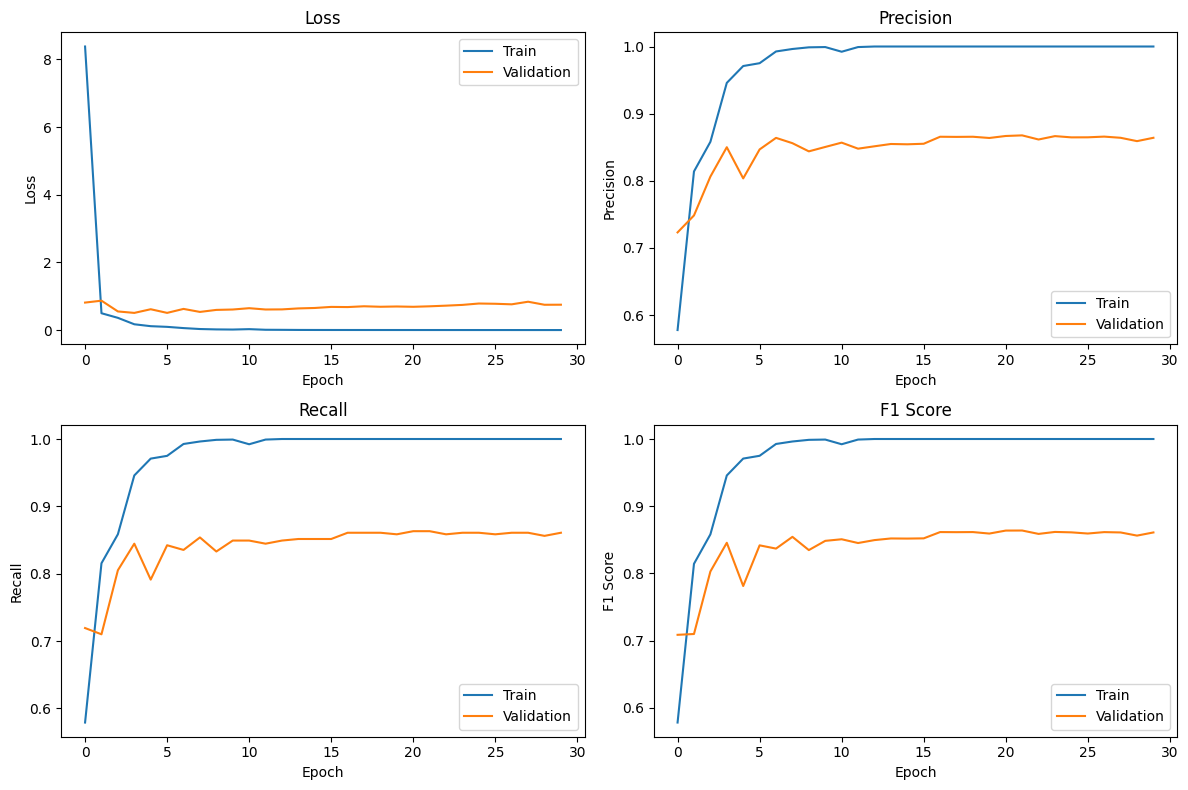

Classification report on test set:
              precision    recall  f1-score   support

           0       0.75      0.21      0.33       100
           1       0.73      0.94      0.82       115
           2       0.62      0.96      0.75       105
           3       0.85      0.64      0.73        74

    accuracy                           0.70       394
   macro avg       0.74      0.69      0.66       394
weighted avg       0.73      0.70      0.66       394



In [311]:
class Classifier1(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model1 = Classifier1()
train(model1)
evaluate_on_test(model1)

# save model for later
with open('classifier1.pkl', 'wb') as f:
    pickle.dump(model1, f)

### Model 2
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* <span style="color:#0e8fc7">Convolutional layer (32 out channels, kernel size 3, padding 1)</span>
* <span style="color:#0e8fc7">ReLU</span>
* <span style="color:#0e8fc7">Max pool (kernel size 2, stride 2)</span>
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.041, V Loss: 0.480, T Precision: 0.992, V Precision: 0.902, T Recall: 0.992, V Recall: 0.896, T F1: 0.992, V F1: 0.896
Epoch [10/30], T Loss: 0.001, V Loss: 0.635, T Precision: 1.000, V Precision: 0.878, T Recall: 1.000, V Recall: 0.877, T F1: 1.000, V F1: 0.877
Epoch [15/30], T Loss: 0.000, V Loss: 0.725, T Precision: 1.000, V Precision: 0.882, T Recall: 1.000, V Recall: 0.882, T F1: 1.000, V F1: 0.881
Epoch [20/30], T Loss: 0.000, V Loss: 0.783, T Precision: 1.000, V Precision: 0.873, T Recall: 1.000, V Recall: 0.872, T F1: 1.000, V F1: 0.872
Epoch [25/30], T Loss: 0.000, V Loss: 0.826, T Precision: 1.000, V Precision: 0.875, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.874
Epoch [30/30], T Loss: 0.000, V Loss: 0.898, T Precision: 1.000, V Precision: 0.874, T Recall: 1.000, V Recall: 0.872, T F1: 1.000, V F1: 0.872


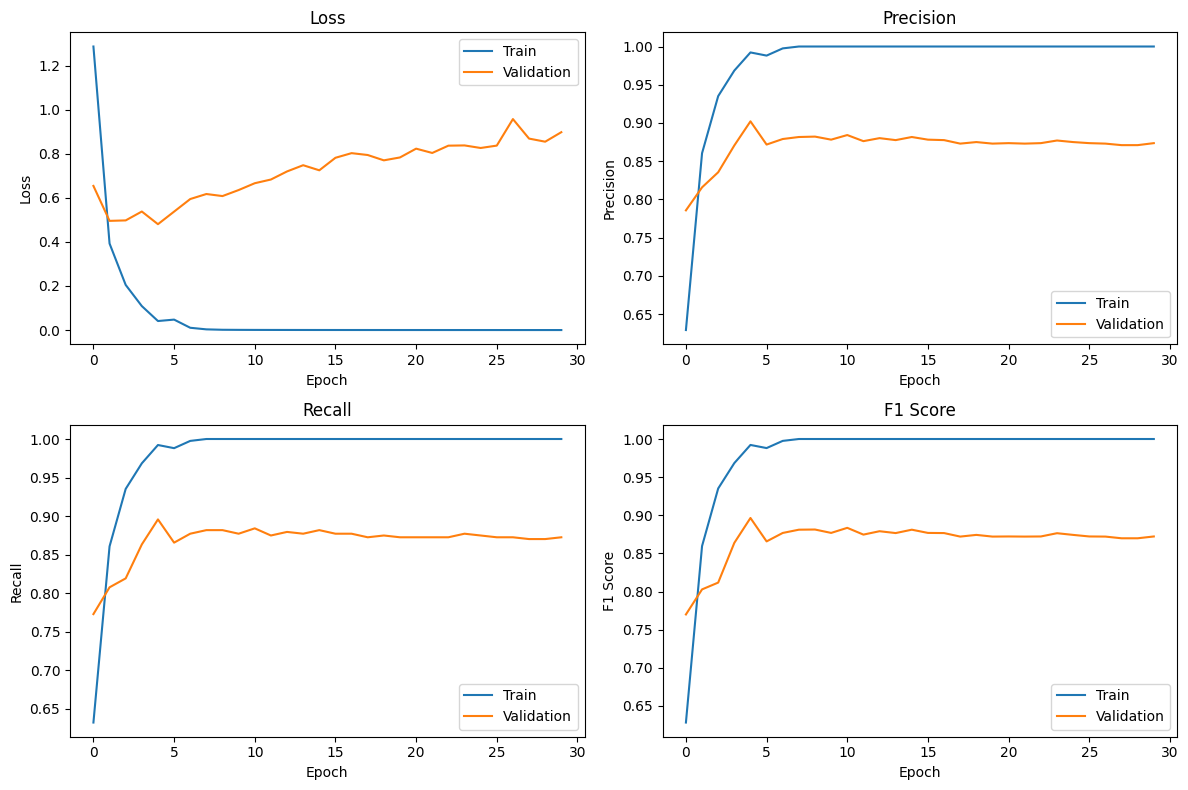

Classification report on test set:
              precision    recall  f1-score   support

           0       0.80      0.20      0.32       100
           1       0.70      0.91      0.79       115
           2       0.60      0.96      0.74       105
           3       0.84      0.57      0.68        74

    accuracy                           0.68       394
   macro avg       0.73      0.66      0.63       394
weighted avg       0.72      0.68      0.64       394



In [312]:
class Classifier2(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 56 * 56)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model2 = Classifier2()
train(model2)
evaluate_on_test(model2)

# save model for later
with open('classifier2.pkl', 'wb') as f:
    pickle.dump(model2, f)

### Model 3
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* <span style="color:#0e8fc7">FC layer from 128 to 64</span>
* <span style="color:#0e8fc7">ReLU</span>
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.071, V Loss: 0.518, T Precision: 0.983, V Precision: 0.842, T Recall: 0.983, V Recall: 0.840, T F1: 0.983, V F1: 0.840
Epoch [10/30], T Loss: 0.002, V Loss: 0.650, T Precision: 1.000, V Precision: 0.871, T Recall: 1.000, V Recall: 0.863, T F1: 1.000, V F1: 0.864
Epoch [15/30], T Loss: 0.000, V Loss: 0.747, T Precision: 1.000, V Precision: 0.868, T Recall: 1.000, V Recall: 0.861, T F1: 1.000, V F1: 0.862
Epoch [20/30], T Loss: 0.000, V Loss: 0.757, T Precision: 1.000, V Precision: 0.865, T Recall: 1.000, V Recall: 0.858, T F1: 1.000, V F1: 0.860
Epoch [25/30], T Loss: 0.000, V Loss: 0.793, T Precision: 1.000, V Precision: 0.866, T Recall: 1.000, V Recall: 0.858, T F1: 1.000, V F1: 0.860
Epoch [30/30], T Loss: 0.000, V Loss: 0.845, T Precision: 1.000, V Precision: 0.860, T Recall: 1.000, V Recall: 0.854, T F1: 1.000, V F1: 0.855


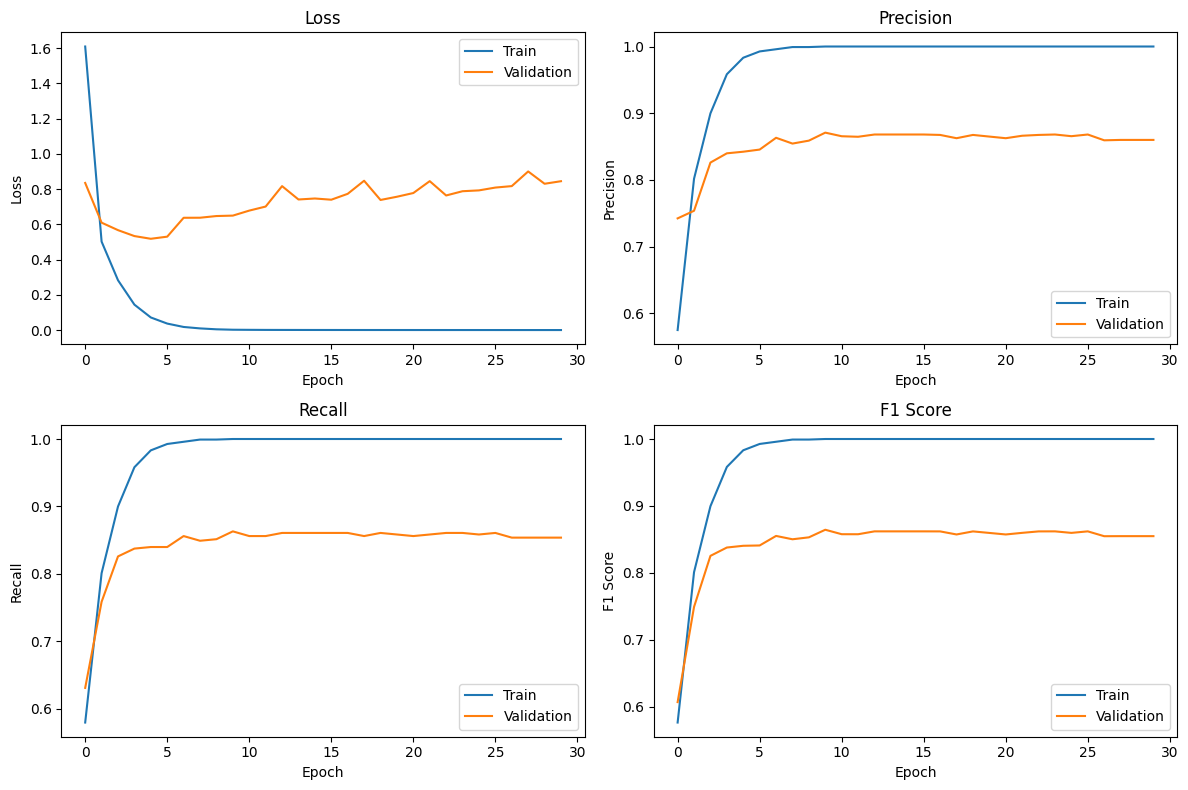

Classification report on test set:
              precision    recall  f1-score   support

           0       0.90      0.19      0.31       100
           1       0.71      0.96      0.81       115
           2       0.62      0.97      0.76       105
           3       0.83      0.61      0.70        74

    accuracy                           0.70       394
   macro avg       0.77      0.68      0.65       394
weighted avg       0.76      0.70      0.65       394



In [315]:
class Classifier3(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, num_classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x

# create the model, train it, and see how well it performs on the test set
model3 = Classifier3()
train(model3)
evaluate_on_test(model3)

# save model for later
with open('classifier3.pkl', 'wb') as f:
    pickle.dump(model3, f)

### Model 4
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
Max pool (kernel size 2, stride 2)
* <span style="color:#0e8fc7">Convolutional layer (32 out channels, kernel size 3, padding size 1)</span>
* <span style="color:#0e8fc7">ReLU</span>
* <span style="color:#0e8fc7">Max pool (kernel size 3, stride 1)</span>
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.066, V Loss: 0.456, T Precision: 0.984, V Precision: 0.879, T Recall: 0.984, V Recall: 0.879, T F1: 0.984, V F1: 0.878
Epoch [10/30], T Loss: 0.002, V Loss: 0.521, T Precision: 1.000, V Precision: 0.897, T Recall: 1.000, V Recall: 0.896, T F1: 1.000, V F1: 0.896
Epoch [15/30], T Loss: 0.000, V Loss: 0.597, T Precision: 1.000, V Precision: 0.897, T Recall: 1.000, V Recall: 0.896, T F1: 1.000, V F1: 0.896
Epoch [20/30], T Loss: 0.000, V Loss: 0.698, T Precision: 1.000, V Precision: 0.900, T Recall: 1.000, V Recall: 0.898, T F1: 1.000, V F1: 0.898
Epoch [25/30], T Loss: 0.000, V Loss: 0.677, T Precision: 1.000, V Precision: 0.900, T Recall: 1.000, V Recall: 0.898, T F1: 1.000, V F1: 0.898
Epoch [30/30], T Loss: 0.000, V Loss: 0.706, T Precision: 1.000, V Precision: 0.892, T Recall: 1.000, V Recall: 0.891, T F1: 1.000, V F1: 0.891


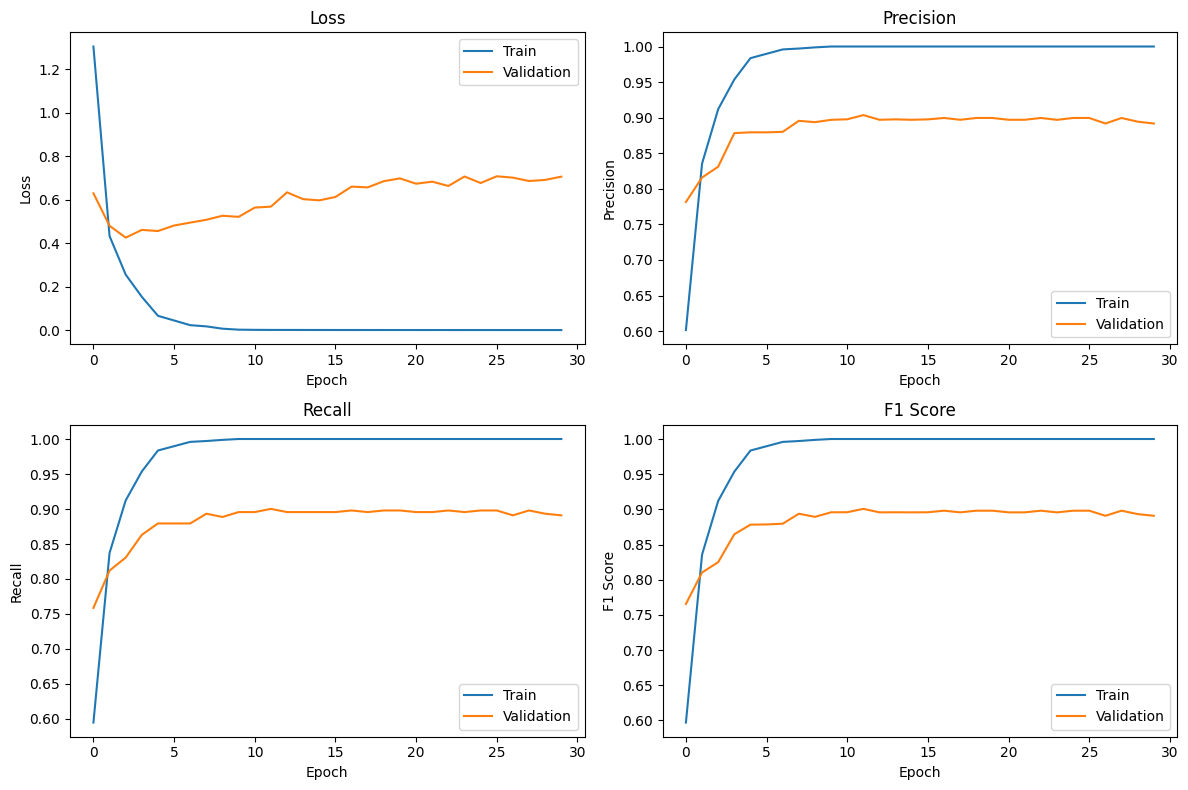

Classification report on test set:
              precision    recall  f1-score   support

           0       0.81      0.22      0.35       100
           1       0.70      0.93      0.80       115
           2       0.63      0.96      0.76       105
           3       0.83      0.59      0.69        74

    accuracy                           0.70       394
   macro avg       0.74      0.68      0.65       394
weighted avg       0.73      0.70      0.65       394



In [331]:
class Classifier4(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)  
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 37 * 37)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model4 = Classifier4()
train(model4)
evaluate_on_test(model4)

# save model for later
with open('classifier4.pkl', 'wb') as f:
    pickle.dump(model4, f)

### Model 5
* Convolutional layer (16 out channels, <span style="color:#0e8fc7">kernel size 5, padding size 2, stride size 2</span>)
* ReLU
* 1 Max pool (kernel size 2, stride 2)
* 1 FC layer to 128
* ReLU
* 1 FC layer to 4 (num classes)

Epoch [5/30], T Loss: 0.067, V Loss: 0.586, T Precision: 0.983, V Precision: 0.862, T Recall: 0.983, V Recall: 0.861, T F1: 0.983, V F1: 0.857
Epoch [10/30], T Loss: 0.002, V Loss: 0.648, T Precision: 1.000, V Precision: 0.871, T Recall: 1.000, V Recall: 0.870, T F1: 1.000, V F1: 0.870
Epoch [15/30], T Loss: 0.001, V Loss: 0.685, T Precision: 1.000, V Precision: 0.871, T Recall: 1.000, V Recall: 0.870, T F1: 1.000, V F1: 0.870
Epoch [20/30], T Loss: 0.000, V Loss: 0.722, T Precision: 1.000, V Precision: 0.876, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875
Epoch [25/30], T Loss: 0.000, V Loss: 0.750, T Precision: 1.000, V Precision: 0.876, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875
Epoch [30/30], T Loss: 0.000, V Loss: 0.780, T Precision: 1.000, V Precision: 0.874, T Recall: 1.000, V Recall: 0.872, T F1: 1.000, V F1: 0.873


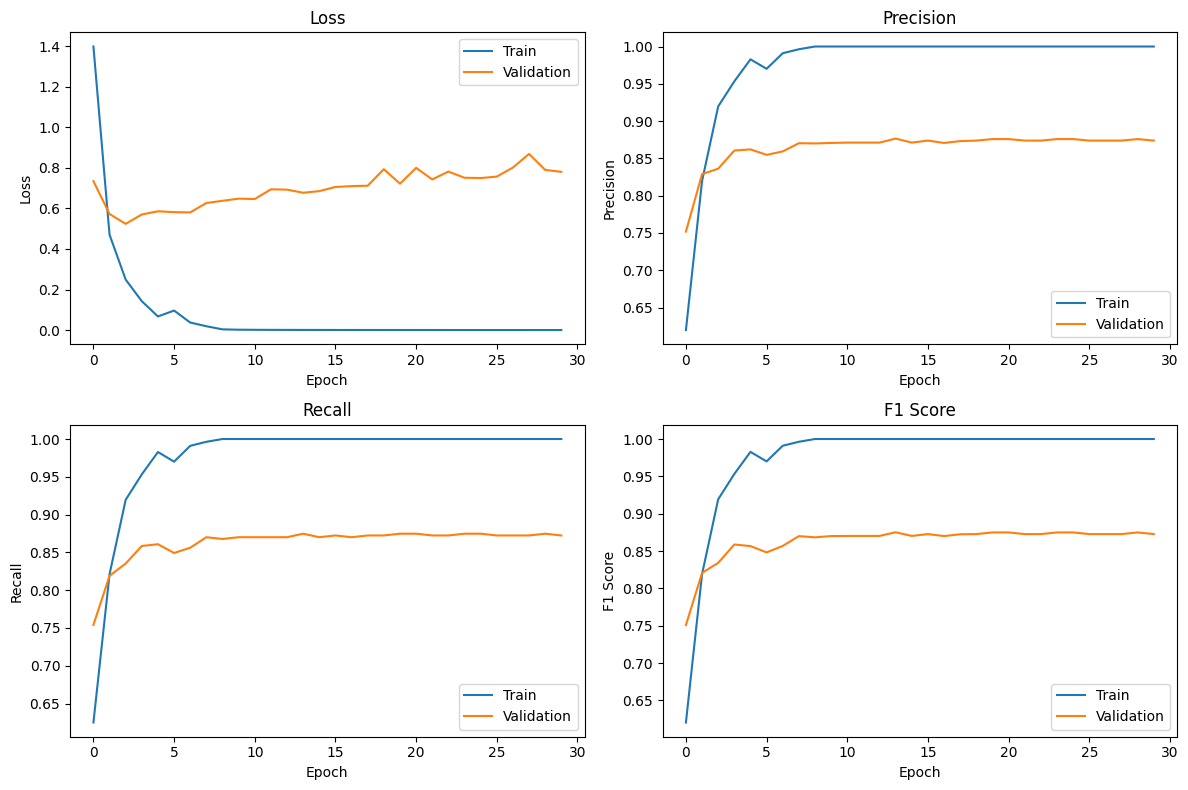

Classification report on test set:
              precision    recall  f1-score   support

           0       0.83      0.19      0.31       100
           1       0.71      0.96      0.81       115
           2       0.64      0.97      0.77       105
           3       0.82      0.62      0.71        74

    accuracy                           0.70       394
   macro avg       0.75      0.68      0.65       394
weighted avg       0.74      0.70      0.65       394



In [317]:
class Classifier5(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = x.view(-1, 16 * 56 * 56)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model5 = Classifier5()
train(model5)
evaluate_on_test(model5)

# save model for later
with open('classifier5.pkl', 'wb') as f:
    pickle.dump(model5, f)

### Model 6
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* <span style="color:#0e8fc7">Sigmoid</span>
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* <span style="color:#0e8fc7">Sigmoid</span>
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 1.352, V Loss: 1.349, T Precision: 0.386, V Precision: 0.796, T Recall: 0.287, V Recall: 0.285, T F1: 0.264, V F1: 0.127
Epoch [10/30], T Loss: 1.354, V Loss: 1.338, T Precision: 0.392, V Precision: 0.778, T Recall: 0.296, V Recall: 0.334, T F1: 0.271, V F1: 0.167
Epoch [15/30], T Loss: 1.353, V Loss: 1.357, T Precision: 0.386, V Precision: 0.811, T Recall: 0.290, V Recall: 0.253, T F1: 0.251, V F1: 0.102
Epoch [20/30], T Loss: 1.352, V Loss: 1.338, T Precision: 0.390, V Precision: 0.778, T Recall: 0.293, V Recall: 0.334, T F1: 0.255, V F1: 0.167
Epoch [25/30], T Loss: 1.353, V Loss: 1.347, T Precision: 0.370, V Precision: 0.778, T Recall: 0.290, V Recall: 0.334, T F1: 0.231, V F1: 0.167
Epoch [30/30], T Loss: 1.356, V Loss: 1.339, T Precision: 0.389, V Precision: 0.778, T Recall: 0.294, V Recall: 0.334, T F1: 0.263, V F1: 0.167


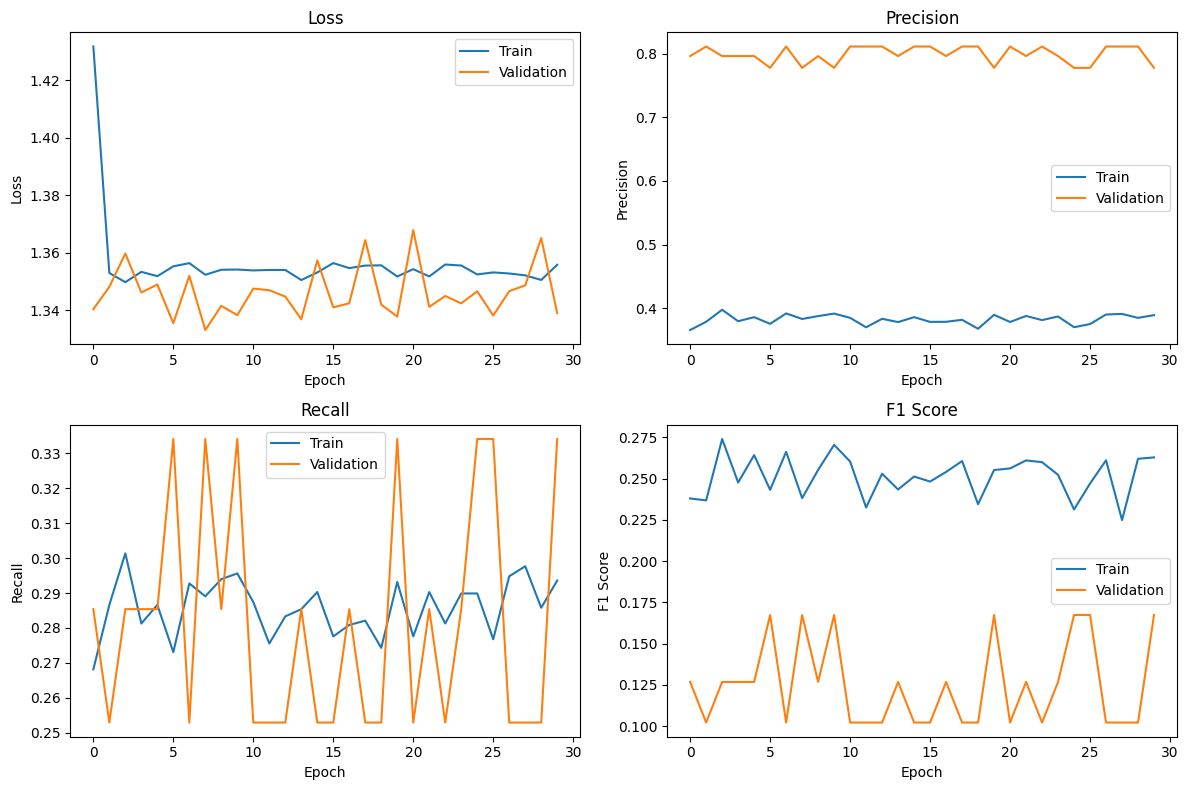

Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       115
           2       0.00      0.00      0.00       105
           3       0.19      1.00      0.32        74

    accuracy                           0.19       394
   macro avg       0.05      0.25      0.08       394
weighted avg       0.04      0.19      0.06       394



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [341]:
class Classifier6(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model6 = Classifier6()
train(model6)
evaluate_on_test(model6)

# save model for later
with open('classifier6.pkl', 'wb') as f:
    pickle.dump(model6, f)

### Model 7
* Convolutional layer (<span style="color:#0e8fc7">32 out channels</span>, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.071, V Loss: 0.520, T Precision: 0.990, V Precision: 0.856, T Recall: 0.990, V Recall: 0.849, T F1: 0.990, V F1: 0.850
Epoch [10/30], T Loss: 0.006, V Loss: 0.606, T Precision: 1.000, V Precision: 0.869, T Recall: 1.000, V Recall: 0.863, T F1: 1.000, V F1: 0.864
Epoch [15/30], T Loss: 0.002, V Loss: 0.653, T Precision: 1.000, V Precision: 0.858, T Recall: 1.000, V Recall: 0.852, T F1: 1.000, V F1: 0.853
Epoch [20/30], T Loss: 0.001, V Loss: 0.697, T Precision: 1.000, V Precision: 0.857, T Recall: 1.000, V Recall: 0.849, T F1: 1.000, V F1: 0.851
Epoch [25/30], T Loss: 0.001, V Loss: 0.727, T Precision: 1.000, V Precision: 0.859, T Recall: 1.000, V Recall: 0.852, T F1: 1.000, V F1: 0.853
Epoch [30/30], T Loss: 0.000, V Loss: 0.741, T Precision: 1.000, V Precision: 0.853, T Recall: 1.000, V Recall: 0.849, T F1: 1.000, V F1: 0.850


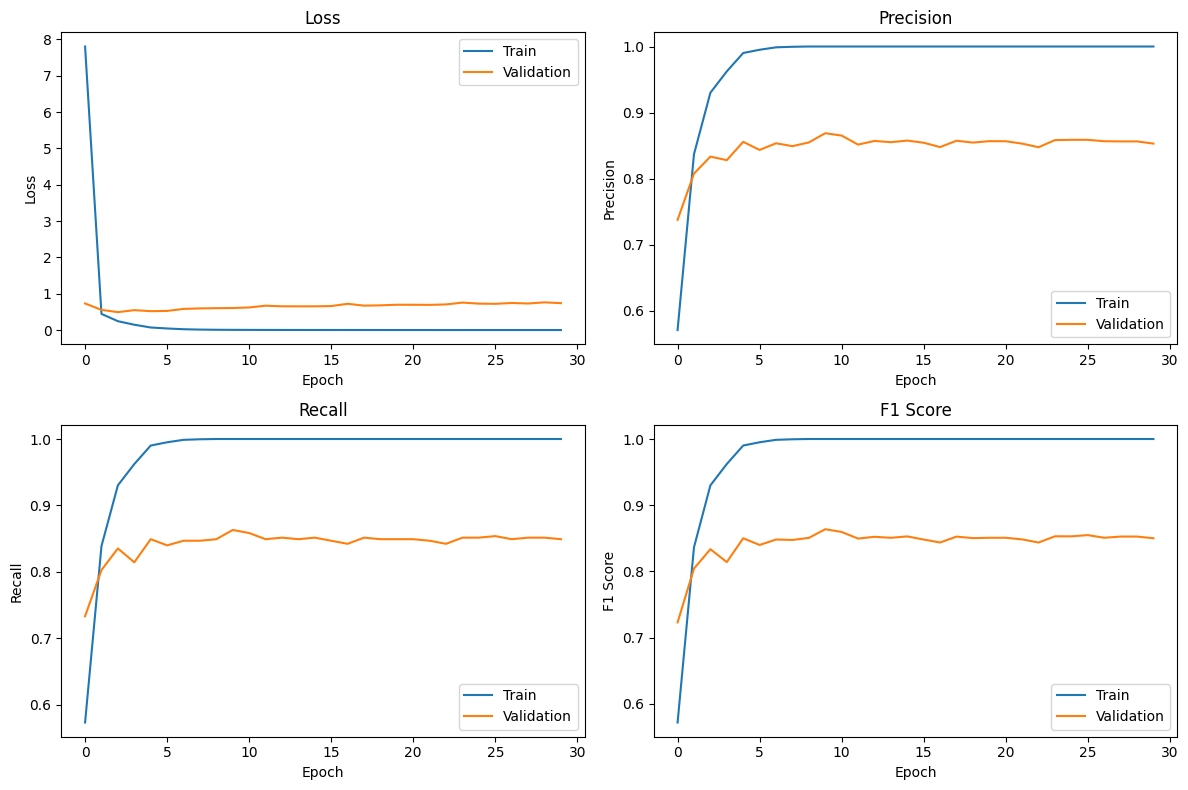

Classification report on test set:
              precision    recall  f1-score   support

           0       0.79      0.19      0.31       100
           1       0.68      0.94      0.79       115
           2       0.62      0.96      0.75       105
           3       0.88      0.57      0.69        74

    accuracy                           0.69       394
   macro avg       0.74      0.66      0.63       394
weighted avg       0.73      0.69      0.64       394



In [319]:
class Classifier7(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier7, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 112 * 112)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model7 = Classifier7()
train(model7)
evaluate_on_test(model7)

# save model for later
with open('classifier7.pkl', 'wb') as f:
    pickle.dump(model7, f)

### Model 8
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* <span style="color:#0e8fc7">Dropout using 0.5</span>
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.343, V Loss: 0.684, T Precision: 0.865, V Precision: 0.811, T Recall: 0.865, V Recall: 0.749, T F1: 0.864, V F1: 0.741
Epoch [10/30], T Loss: 0.079, V Loss: 0.547, T Precision: 0.980, V Precision: 0.866, T Recall: 0.980, V Recall: 0.865, T F1: 0.980, V F1: 0.865
Epoch [15/30], T Loss: 0.007, V Loss: 0.705, T Precision: 1.000, V Precision: 0.865, T Recall: 1.000, V Recall: 0.861, T F1: 1.000, V F1: 0.860
Epoch [20/30], T Loss: 0.004, V Loss: 0.770, T Precision: 1.000, V Precision: 0.874, T Recall: 1.000, V Recall: 0.872, T F1: 1.000, V F1: 0.872
Epoch [25/30], T Loss: 0.003, V Loss: 0.834, T Precision: 1.000, V Precision: 0.870, T Recall: 1.000, V Recall: 0.870, T F1: 1.000, V F1: 0.869
Epoch [30/30], T Loss: 0.003, V Loss: 0.829, T Precision: 1.000, V Precision: 0.871, T Recall: 1.000, V Recall: 0.870, T F1: 1.000, V F1: 0.869


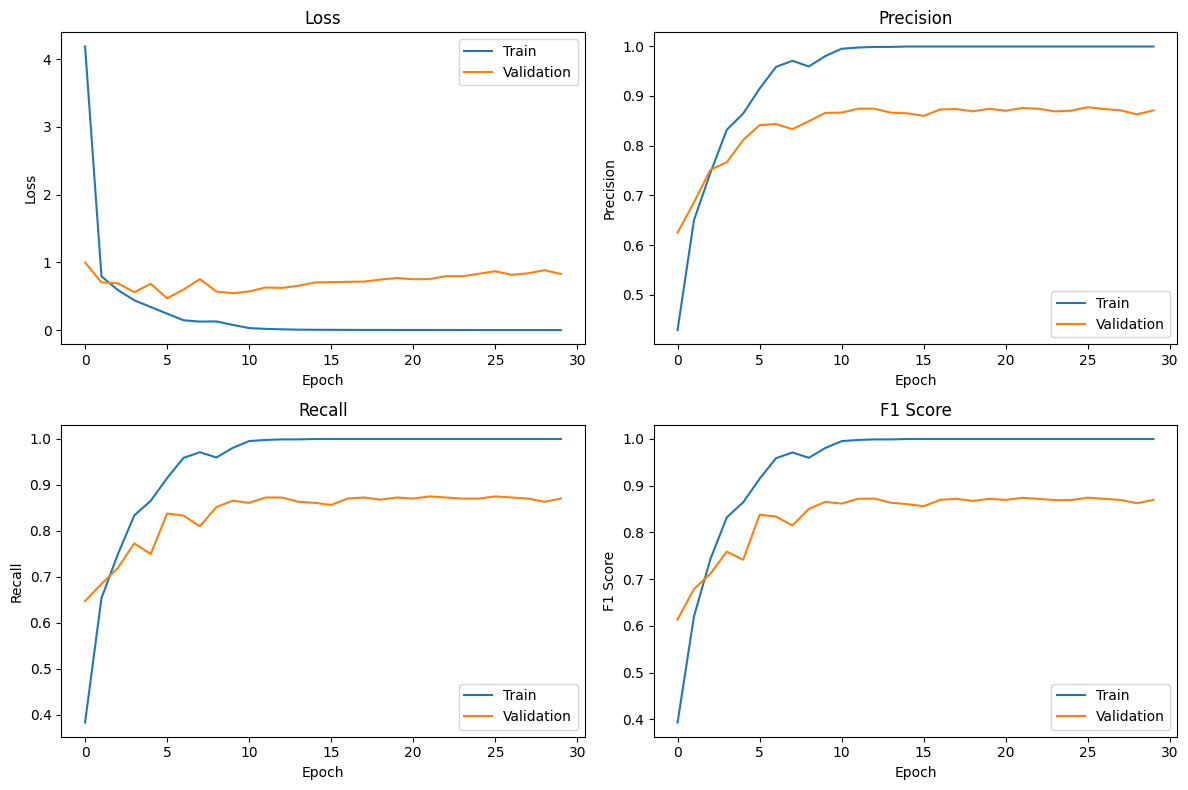

Classification report on test set:
              precision    recall  f1-score   support

           0       0.81      0.22      0.35       100
           1       0.68      0.94      0.79       115
           2       0.64      0.97      0.77       105
           3       0.82      0.55      0.66        74

    accuracy                           0.69       394
   macro avg       0.74      0.67      0.64       394
weighted avg       0.73      0.69      0.65       394



In [18]:
class Classifier8(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier8, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model8 = Classifier8()
train(model8)
evaluate_on_test(model8)

# save model for later
import pickle
with open('classifier8.pkl', 'wb') as f:
    pickle.dump(model8, f)

### Model 9
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* <span style="color:#0e8fc7">Batch norm (16 channels)</span>
* ReLU
* <span style="color:#0e8fc7">Avg pool</span> (kernel size 2, stride 2)
* <span style="color:#0e8fc7">Convolutional layer (32 out channels, kernel size 3, padding size 1)</span>
* <span style="color:#0e8fc7">Batch norm (16 channels)</span>
* <span style="color:#0e8fc7">ReLU</span>
* <span style="color:#0e8fc7">Avg pool</span> (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

Epoch [5/30], T Loss: 0.134, V Loss: 0.455, T Precision: 0.956, V Precision: 0.869, T Recall: 0.957, V Recall: 0.856, T F1: 0.957, V F1: 0.856
Epoch [10/30], T Loss: 0.010, V Loss: 0.551, T Precision: 0.998, V Precision: 0.882, T Recall: 0.998, V Recall: 0.879, T F1: 0.998, V F1: 0.879
Epoch [15/30], T Loss: 0.001, V Loss: 0.605, T Precision: 1.000, V Precision: 0.886, T Recall: 1.000, V Recall: 0.886, T F1: 1.000, V F1: 0.886
Epoch [20/30], T Loss: 0.000, V Loss: 0.619, T Precision: 1.000, V Precision: 0.884, T Recall: 1.000, V Recall: 0.884, T F1: 1.000, V F1: 0.883
Epoch [25/30], T Loss: 0.000, V Loss: 0.651, T Precision: 1.000, V Precision: 0.882, T Recall: 1.000, V Recall: 0.882, T F1: 1.000, V F1: 0.881
Epoch [30/30], T Loss: 0.000, V Loss: 0.684, T Precision: 1.000, V Precision: 0.886, T Recall: 1.000, V Recall: 0.886, T F1: 1.000, V F1: 0.886


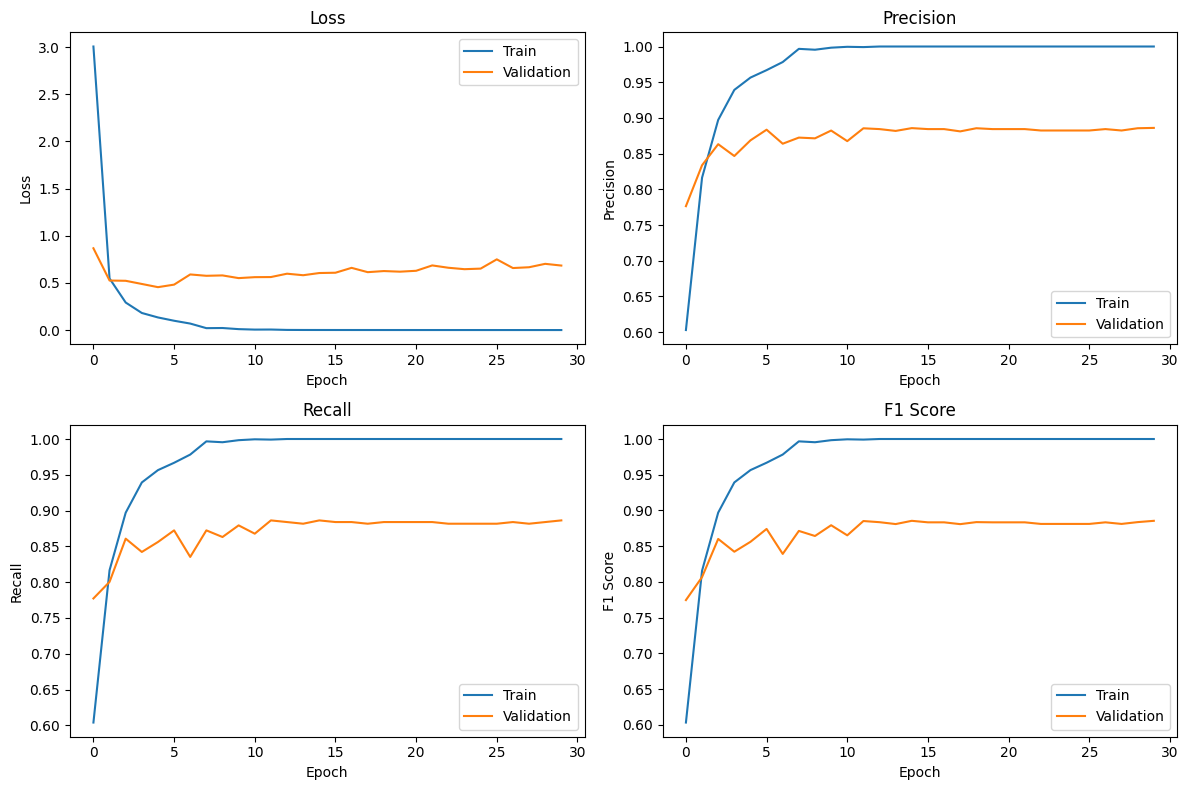

Classification report on test set:
              precision    recall  f1-score   support

           0       0.83      0.20      0.32       100
           1       0.74      0.96      0.83       115
           2       0.59      0.96      0.73       105
           3       0.88      0.59      0.71        74

    accuracy                           0.70       394
   macro avg       0.76      0.68      0.65       394
weighted avg       0.75      0.70      0.65       394



In [334]:
class Classifier9(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier9, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) 
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128) 
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.avg_pool(F.relu(self.bn1(self.conv1(x)))) 
        x = self.avg_pool(F.relu(self.bn2(self.conv2(x))))  
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model9 = Classifier9()
train(model9)
evaluate_on_test(model9)

# save model for later
import pickle
with open('classifier9.pkl', 'wb') as f:
    pickle.dump(model9, f)

### Model 10
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* <span style="color:#0e8fc7">Avg pool</span> (kernel size 2, stride 2)
* <span style="color:#0e8fc7">Convolutional layer (32 out channels, kernel size 3, padding size 1)</span>
* <span style="color:#0e8fc7">ReLU</span>
* <span style="color:#0e8fc7">Avg pool</span> (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.090, V Loss: 0.368, T Precision: 0.976, V Precision: 0.903, T Recall: 0.976, V Recall: 0.903, T F1: 0.976, V F1: 0.903
Epoch [10/30], T Loss: 0.001, V Loss: 0.492, T Precision: 1.000, V Precision: 0.894, T Recall: 1.000, V Recall: 0.893, T F1: 1.000, V F1: 0.893
Epoch [15/30], T Loss: 0.000, V Loss: 0.607, T Precision: 1.000, V Precision: 0.893, T Recall: 1.000, V Recall: 0.891, T F1: 1.000, V F1: 0.891
Epoch [20/30], T Loss: 0.000, V Loss: 0.617, T Precision: 1.000, V Precision: 0.892, T Recall: 1.000, V Recall: 0.891, T F1: 1.000, V F1: 0.891
Epoch [25/30], T Loss: 0.000, V Loss: 0.653, T Precision: 1.000, V Precision: 0.897, T Recall: 1.000, V Recall: 0.896, T F1: 1.000, V F1: 0.895
Epoch [30/30], T Loss: 0.000, V Loss: 0.644, T Precision: 1.000, V Precision: 0.894, T Recall: 1.000, V Recall: 0.893, T F1: 1.000, V F1: 0.893


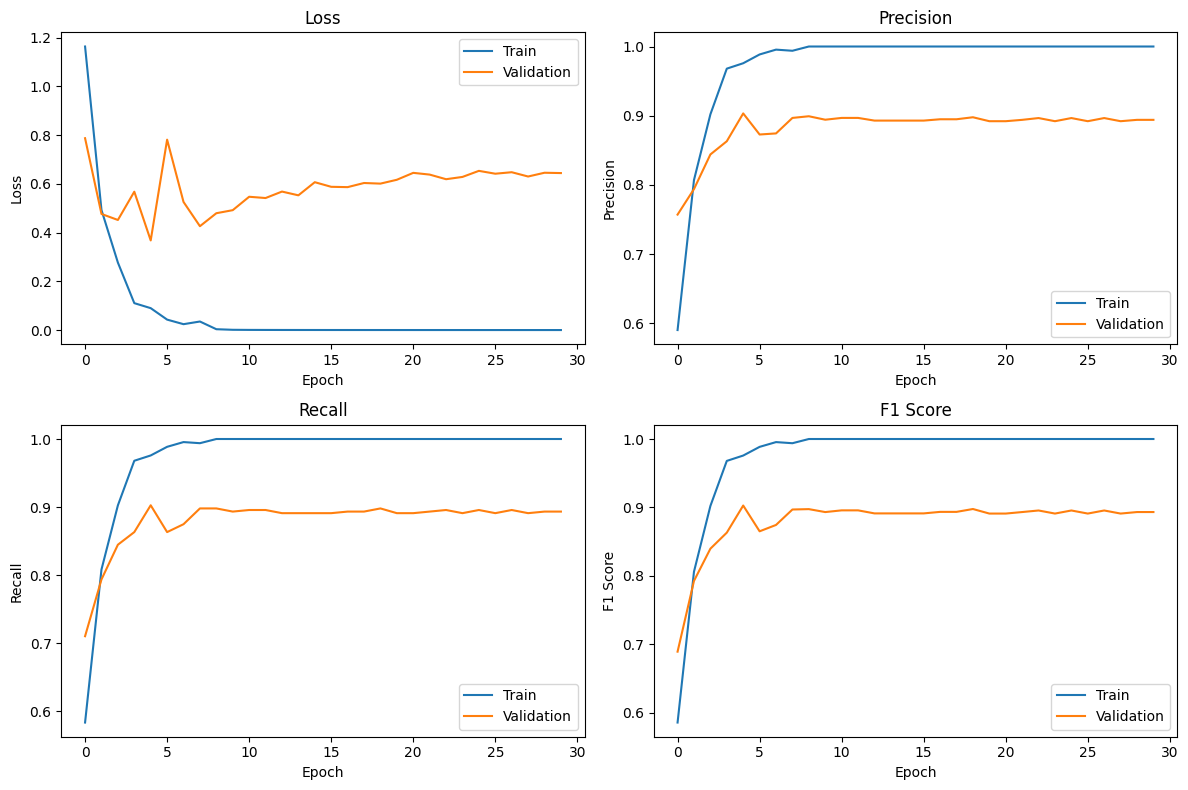

Classification report on test set:
              precision    recall  f1-score   support

           0       0.96      0.23      0.37       100
           1       0.70      0.91      0.79       115
           2       0.61      0.98      0.75       105
           3       0.86      0.59      0.70        74

    accuracy                           0.70       394
   macro avg       0.78      0.68      0.65       394
weighted avg       0.77      0.70      0.66       394



In [22]:
class Classifier10(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Change to AvgPool2d
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.avg_pool(F.relu(self.conv1(x)))
        x = self.avg_pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model10 = Classifier10()
train(model10)
evaluate_on_test(model10)

# save model for later
import pickle
with open('classifier10.pkl', 'wb') as f:
    pickle.dump(model10, f)

### Model 11
* <span style="color:#0e8fc7">batch size 64</span>
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

In [323]:
batch_size = 64
trainset_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valset_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
testset_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.192, V Loss: 0.512, T Precision: 0.948, V Precision: 0.834, T Recall: 0.947, V Recall: 0.828, T F1: 0.947, V F1: 0.828
Epoch [10/30], T Loss: 0.036, V Loss: 0.539, T Precision: 0.995, V Precision: 0.839, T Recall: 0.995, V Recall: 0.835, T F1: 0.995, V F1: 0.835
Epoch [15/30], T Loss: 0.009, V Loss: 0.618, T Precision: 1.000, V Precision: 0.838, T Recall: 1.000, V Recall: 0.833, T F1: 1.000, V F1: 0.834
Epoch [20/30], T Loss: 0.004, V Loss: 0.623, T Precision: 1.000, V Precision: 0.842, T Recall: 1.000, V Recall: 0.840, T F1: 1.000, V F1: 0.840
Epoch [25/30], T Loss: 0.002, V Loss: 0.685, T Precision: 1.000, V Precision: 0.841, T Recall: 1.000, V Recall: 0.838, T F1: 1.000, V F1: 0.838
Epoch [30/30], T Loss: 0.002, V Loss: 0.690, T Precision: 1.000, V Precision: 0.844, T Recall: 1.000, V Recall: 0.842, T F1: 1.000, V F1: 0.842


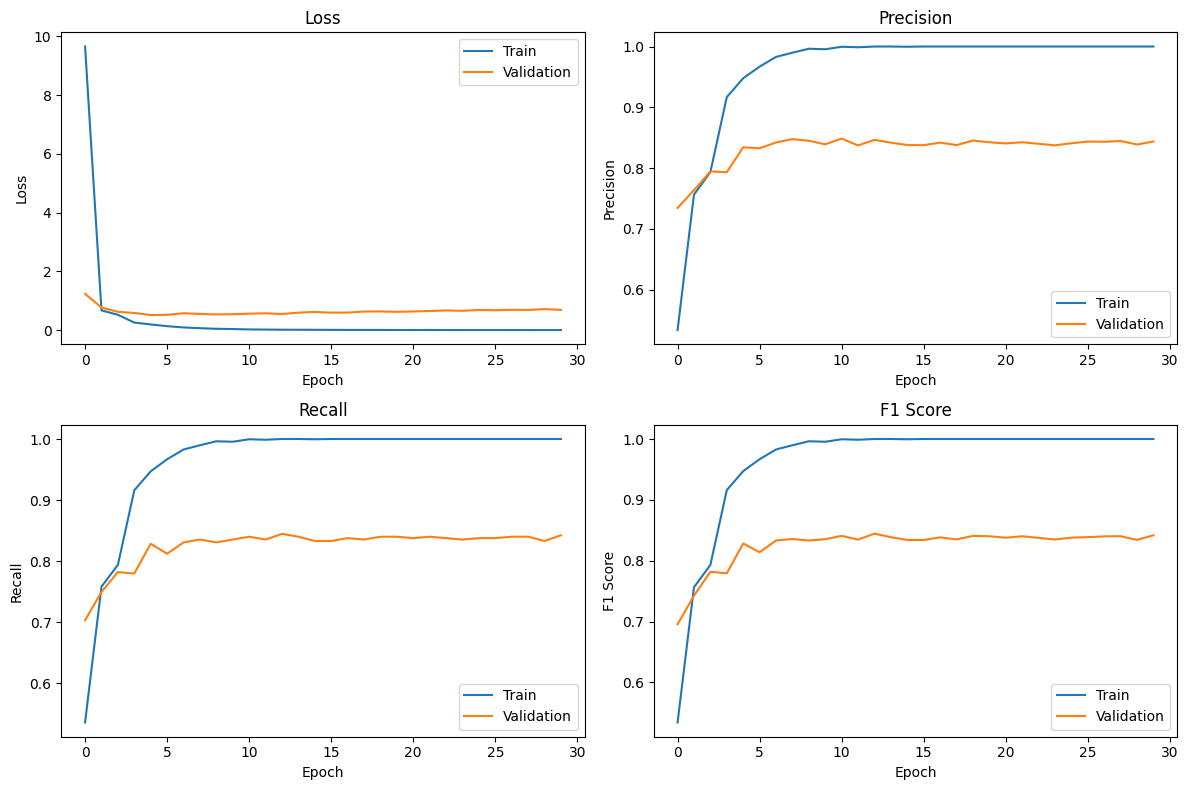

Classification report on test set:
              precision    recall  f1-score   support

           0       0.70      0.19      0.30       100
           1       0.74      0.93      0.82       115
           2       0.59      0.96      0.73       105
           3       0.85      0.59      0.70        74

    accuracy                           0.69       394
   macro avg       0.72      0.67      0.64       394
weighted avg       0.71      0.69      0.64       394



In [324]:
class Classifier11(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier11, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model11 = Classifier11()
train(model11)
evaluate_on_test(model11)

# save model for later
import pickle
with open('classifier11.pkl', 'wb') as f:
    pickle.dump(model11, f)

### Model 12
* <span style="color:#0e8fc7">batch size 16</span>
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* ReLU
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

In [325]:
batch_size = 16
trainset_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valset_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
testset_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.125, V Loss: 0.604, T Precision: 0.963, V Precision: 0.846, T Recall: 0.963, V Recall: 0.826, T F1: 0.963, V F1: 0.828
Epoch [10/30], T Loss: 0.005, V Loss: 0.737, T Precision: 1.000, V Precision: 0.845, T Recall: 1.000, V Recall: 0.838, T F1: 1.000, V F1: 0.839
Epoch [15/30], T Loss: 0.001, V Loss: 0.800, T Precision: 1.000, V Precision: 0.837, T Recall: 1.000, V Recall: 0.835, T F1: 1.000, V F1: 0.835
Epoch [20/30], T Loss: 0.000, V Loss: 0.861, T Precision: 1.000, V Precision: 0.841, T Recall: 1.000, V Recall: 0.838, T F1: 1.000, V F1: 0.838
Epoch [25/30], T Loss: 0.000, V Loss: 0.910, T Precision: 1.000, V Precision: 0.846, T Recall: 1.000, V Recall: 0.842, T F1: 1.000, V F1: 0.843
Epoch [30/30], T Loss: 0.000, V Loss: 0.958, T Precision: 1.000, V Precision: 0.848, T Recall: 1.000, V Recall: 0.845, T F1: 1.000, V F1: 0.845


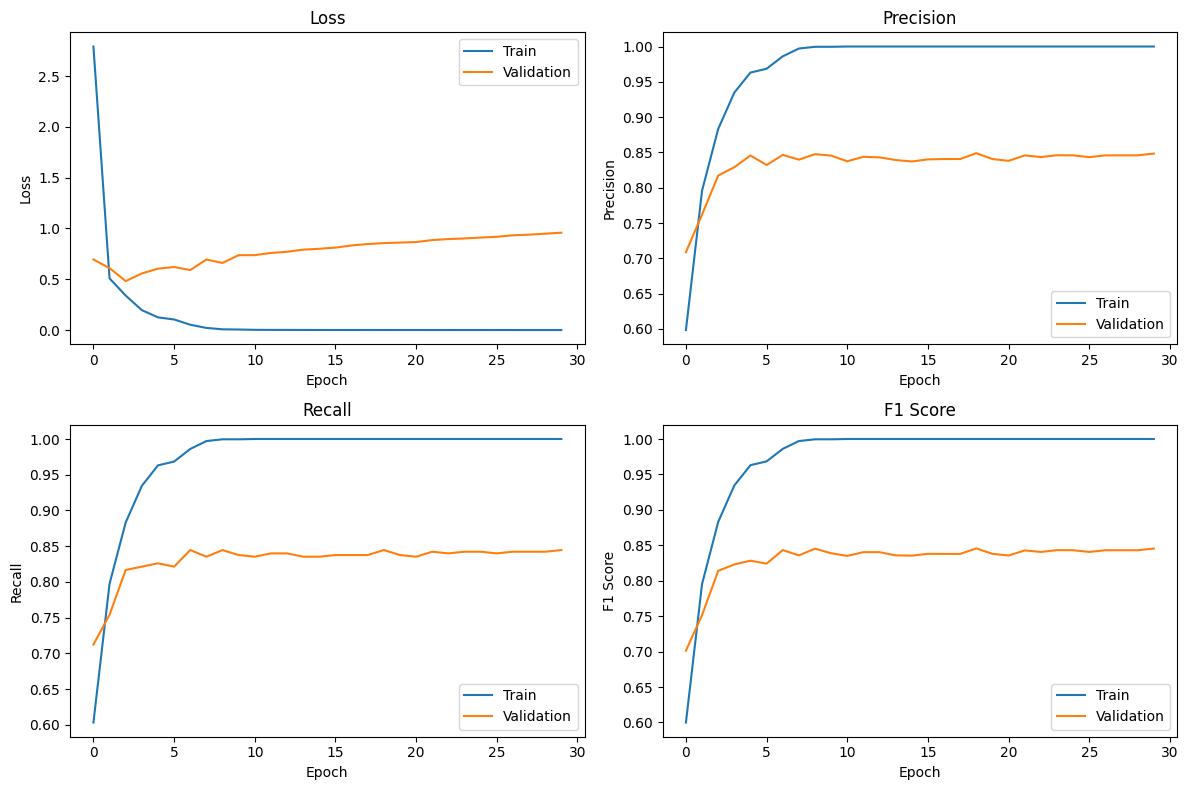

Classification report on test set:
              precision    recall  f1-score   support

           0       0.90      0.19      0.31       100
           1       0.67      0.92      0.78       115
           2       0.63      0.97      0.76       105
           3       0.83      0.58      0.68        74

    accuracy                           0.69       394
   macro avg       0.76      0.67      0.63       394
weighted avg       0.75      0.69      0.64       394



In [326]:
class Classifier12(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier12, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model12 = Classifier12()
train(model12)
evaluate_on_test(model12)

# save model for later
import pickle
with open('classifier12.pkl', 'wb') as f:
    pickle.dump(model12, f)

### Model 13
* Convolutional layer (16 out channels, <span style="color:#0e8fc7">kernel size 4, padding size 0</span>)
* ReLU
* Max pool (<span style="color:#0e8fc7">kernel size 4, stride size 0)</span>
* FC layer to 128
* ReLU
* FC layer to 4 (num classes)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/30], T Loss: 0.073, V Loss: 0.464, T Precision: 0.982, V Precision: 0.863, T Recall: 0.982, V Recall: 0.852, T F1: 0.982, V F1: 0.854
Epoch [10/30], T Loss: 0.013, V Loss: 0.552, T Precision: 0.999, V Precision: 0.884, T Recall: 0.999, V Recall: 0.879, T F1: 0.999, V F1: 0.880
Epoch [15/30], T Loss: 0.001, V Loss: 0.571, T Precision: 1.000, V Precision: 0.876, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875
Epoch [20/30], T Loss: 0.000, V Loss: 0.608, T Precision: 1.000, V Precision: 0.881, T Recall: 1.000, V Recall: 0.879, T F1: 1.000, V F1: 0.880
Epoch [25/30], T Loss: 0.000, V Loss: 0.629, T Precision: 1.000, V Precision: 0.876, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875
Epoch [30/30], T Loss: 0.000, V Loss: 0.634, T Precision: 1.000, V Precision: 0.876, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875


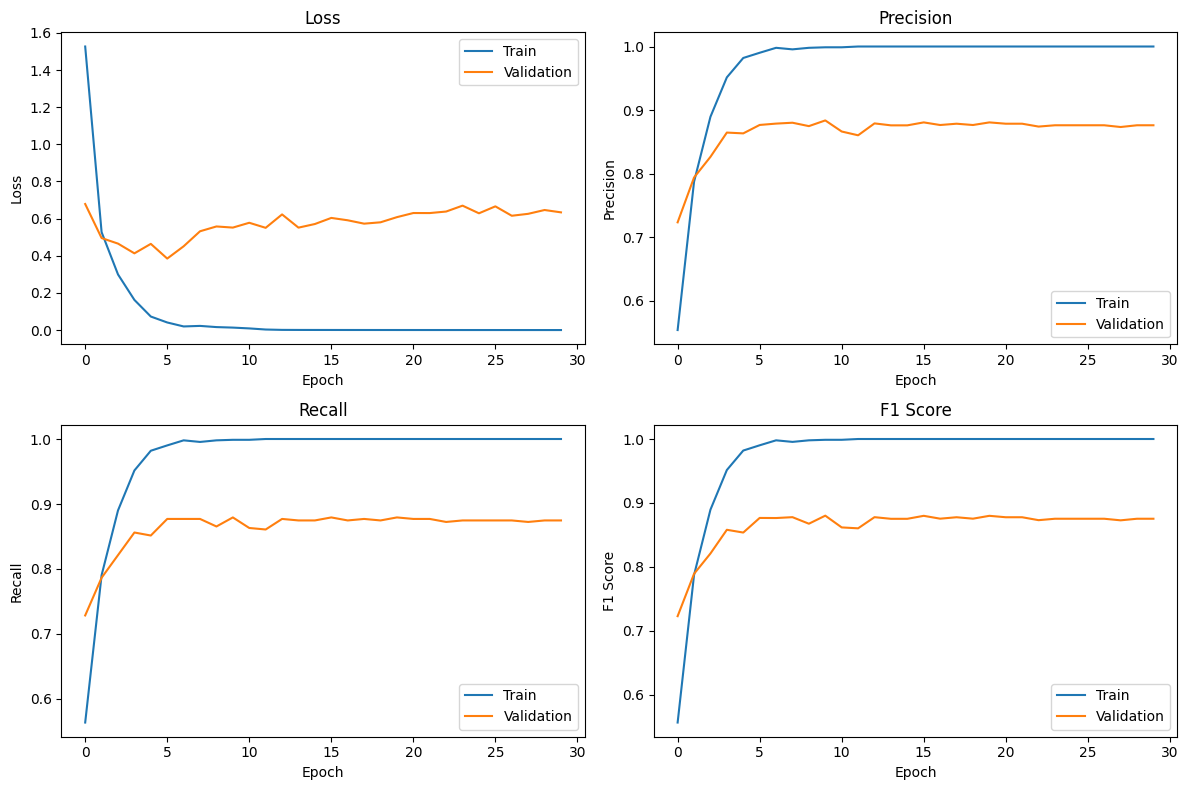

Classification report on test set:
              precision    recall  f1-score   support

           0       0.71      0.20      0.31       100
           1       0.74      0.92      0.82       115
           2       0.59      0.97      0.73       105
           3       0.83      0.54      0.66        74

    accuracy                           0.68       394
   macro avg       0.72      0.66      0.63       394
weighted avg       0.71      0.68      0.64       394



In [337]:
# switching batch size back to the "standard" for the rest of the models
batch_size = 32
trainset_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valset_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
testset_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Classifier13(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier13, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4) 
        self.pool = nn.MaxPool2d(kernel_size=4) 
        self.fc1 = nn.LazyLinear(120)
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 55 * 55)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model13 = Classifier13()
train(model13)
evaluate_on_test(model13)

# save model for later
import pickle
with open('classifier13.pkl', 'wb') as f:
    pickle.dump(model13, f)

### Model 14
* Convolutional layer (16 out channels, kernel size 3, padding size 1)
* <span style="color:#0e8fc7">Leaky ReLU</span>
* Max pool (kernel size 2, stride 2)
* FC layer to 128
* <span style="color:#0e8fc7">Leaky ReLU</span>
* FC layer to 4 (num classes)

Epoch [5/30], T Loss: 0.101, V Loss: 0.540, T Precision: 0.980, V Precision: 0.860, T Recall: 0.980, V Recall: 0.842, T F1: 0.980, V F1: 0.843
Epoch [10/30], T Loss: 0.004, V Loss: 0.554, T Precision: 1.000, V Precision: 0.871, T Recall: 1.000, V Recall: 0.868, T F1: 1.000, V F1: 0.868
Epoch [15/30], T Loss: 0.001, V Loss: 0.608, T Precision: 1.000, V Precision: 0.873, T Recall: 1.000, V Recall: 0.870, T F1: 1.000, V F1: 0.870
Epoch [20/30], T Loss: 0.001, V Loss: 0.645, T Precision: 1.000, V Precision: 0.870, T Recall: 1.000, V Recall: 0.865, T F1: 1.000, V F1: 0.866
Epoch [25/30], T Loss: 0.000, V Loss: 0.663, T Precision: 1.000, V Precision: 0.871, T Recall: 1.000, V Recall: 0.868, T F1: 1.000, V F1: 0.868
Epoch [30/30], T Loss: 0.000, V Loss: 0.692, T Precision: 1.000, V Precision: 0.869, T Recall: 1.000, V Recall: 0.865, T F1: 1.000, V F1: 0.866


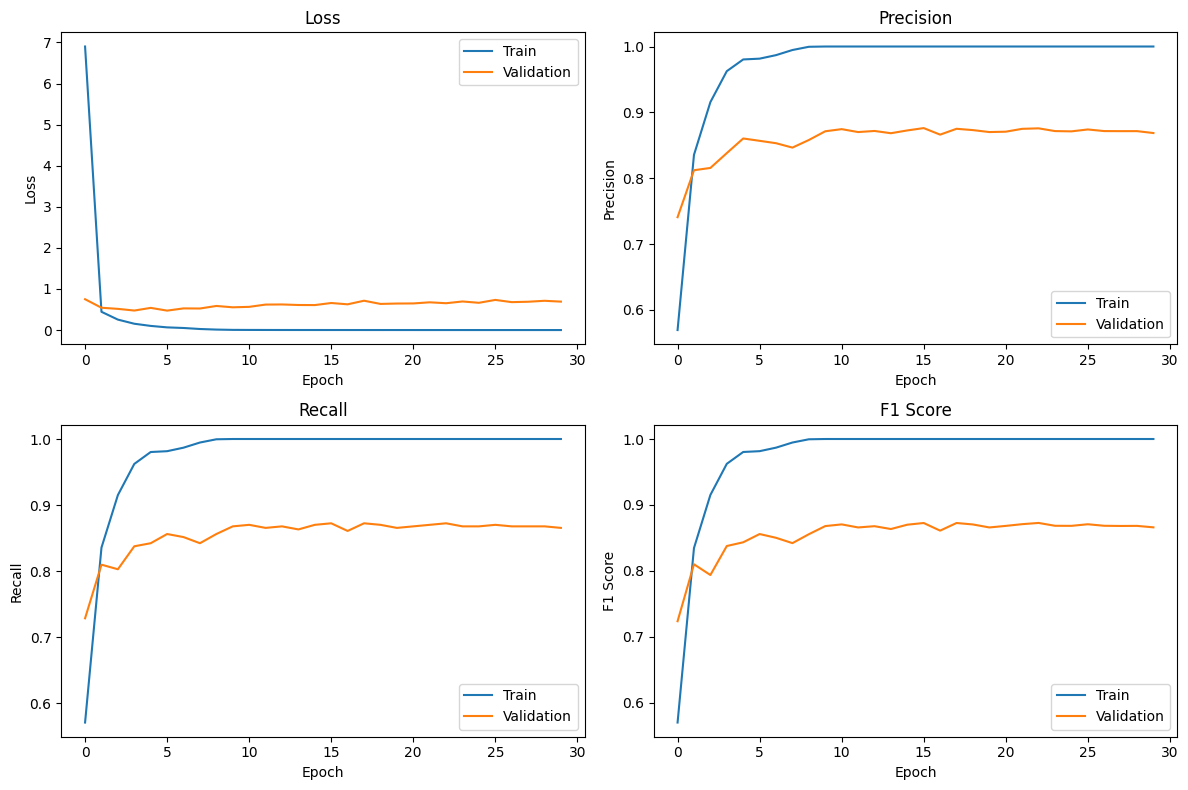

Classification report on test set:
              precision    recall  f1-score   support

           0       0.72      0.18      0.29       100
           1       0.71      0.96      0.81       115
           2       0.63      0.97      0.76       105
           3       0.86      0.59      0.70        74

    accuracy                           0.70       394
   macro avg       0.73      0.68      0.64       394
weighted avg       0.72      0.70      0.65       394



In [336]:
class Classifier14(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier14, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.2))  # Using Leaky ReLU here
        x = x.view(-1, 16 * 112 * 112)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)  # Using Leaky ReLU here
        x = self.fc2(x)
        return x

# create the model, train it, and see how well it performs on the test set
model14 = Classifier14()
train(model14)
evaluate_on_test(model14)

# save model for later
with open('classifier14.pkl', 'wb') as f:
    pickle.dump(model14, f)

### Model 15
* Convolutional layer (<span style="color:#0e8fc7">12 out channels</span>, kernel size 3, <span style="color:#0e8fc7">stride size 2</span>, padding size 1)
* <span style="color:#0e8fc7">Batch norm with 12 channels</span>
* ReLU
* Max pool (kernel size 2, <span style="color:#0e8fc7">stride size 0</span>)
* <span style="color:#0e8fc7">Convolutional layer (20 out channels, kernel size 3, stride size 1, padding size 1)</span>
* <span style="color:#0e8fc7">ReLU</span>
* <span style="color:#0e8fc7">Convolutional layer (32 out channels, kernel size 3, stride size 1, padding size 1)</span>
* <span style="color:#0e8fc7">Batch norm with 32 channels</span>
* <span style="color:#0e8fc7">ReLU</span>
* <span style="color:#0e8fc7">No FC layer to 128</span>
* <span style="color:#0e8fc7">No ReLU</span>
* FC layer to 4 (num classes)

Epoch [5/30], T Loss: 0.012, V Loss: 0.670, T Precision: 0.997, V Precision: 0.863, T Recall: 0.997, V Recall: 0.863, T F1: 0.997, V F1: 0.863
Epoch [10/30], T Loss: 0.001, V Loss: 0.741, T Precision: 1.000, V Precision: 0.867, T Recall: 1.000, V Recall: 0.865, T F1: 1.000, V F1: 0.866
Epoch [15/30], T Loss: 0.000, V Loss: 0.811, T Precision: 1.000, V Precision: 0.875, T Recall: 1.000, V Recall: 0.872, T F1: 1.000, V F1: 0.873
Epoch [20/30], T Loss: 0.000, V Loss: 0.917, T Precision: 1.000, V Precision: 0.873, T Recall: 1.000, V Recall: 0.870, T F1: 1.000, V F1: 0.871
Epoch [25/30], T Loss: 0.000, V Loss: 0.903, T Precision: 1.000, V Precision: 0.877, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875
Epoch [30/30], T Loss: 0.000, V Loss: 0.921, T Precision: 1.000, V Precision: 0.877, T Recall: 1.000, V Recall: 0.875, T F1: 1.000, V F1: 0.875


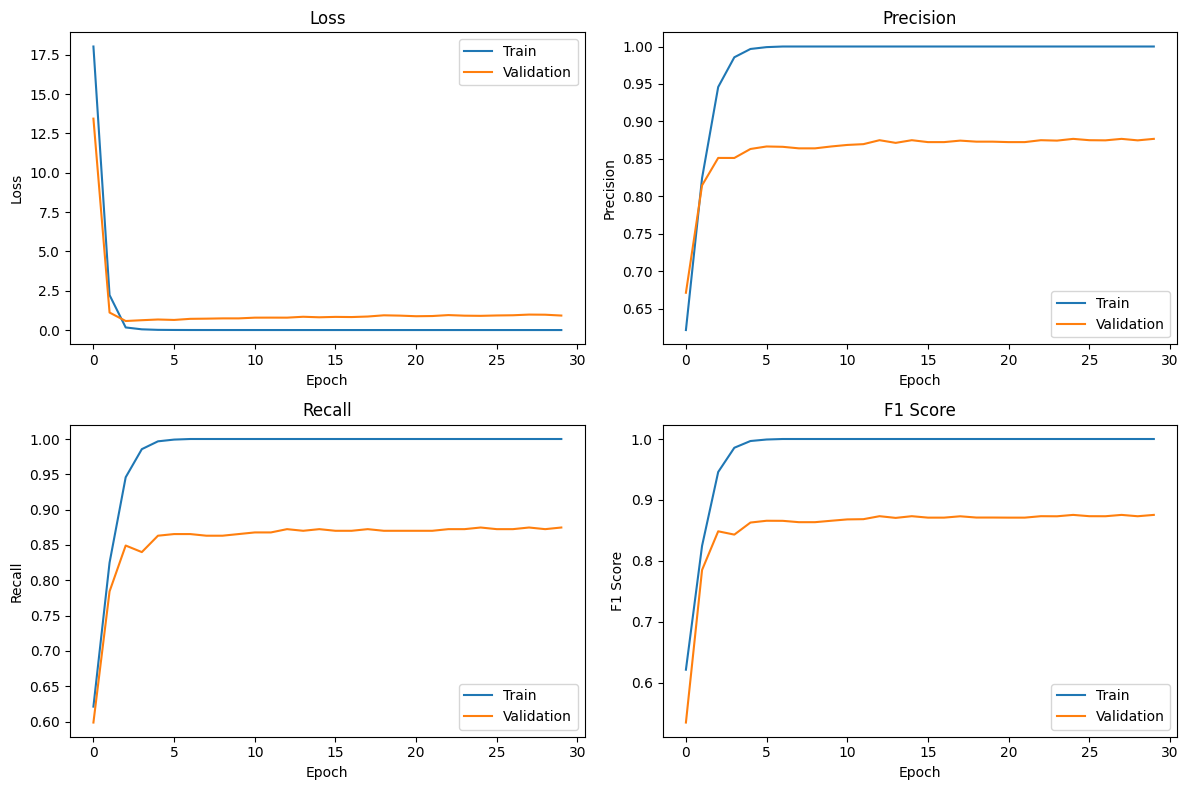

Classification report on test set:
              precision    recall  f1-score   support

           0       0.72      0.21      0.33       100
           1       0.70      0.92      0.80       115
           2       0.60      0.97      0.74       105
           3       0.86      0.50      0.63        74

    accuracy                           0.68       394
   macro avg       0.72      0.65      0.62       394
weighted avg       0.71      0.68      0.63       394



In [350]:
class Classifier15(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier15, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)    
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=32)
        self.fc=nn.LazyLinear(num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x  =F.relu(self.conv2(x))
        x = F.relu(self.bn2(self.conv3(x)))
        x = x.view(-1,32*112*112)
        x = self.fc(x)
        return x 

# create the model, train it, and see how well it performs on the test set
model15 = Classifier15()
train(model15)
evaluate_on_test(model15)

# save model for later
with open('classifier15.pkl', 'wb') as f:
    pickle.dump(model15, f)

## Experiment 1 Results

We will use the F2 metric to select our final model, since this metric provides a balance between precision and recall. We value precision because we want to make sure that when our model predicts a patient's MRI positively, it is correct; we value recall because we want to make sure that we can identify as many patients with tumors as possible. Although model 10 and model 1 have the same F2-score and accuracy, model 10 has a better weighted precision by 0.07, therefore we will use model 10.

In [1]:
import torch.nn as nn 
class Classifier10(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Change to AvgPool2d
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.avg_pool(F.relu(self.conv1(x)))
        x = self.avg_pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [86]:
import pickle
with open('classifier10.pkl', 'rb') as f:
    model = pickle.load(f)

## Experiment 2: Transfer Learning on New Dataset

In the second experiment, we will utilize the highest performing model from Experiment 1 (model 10) on a new dataset. Some of the brain tumor classes in the new dataset are shared by the previous one, but each class is further decomposed into three different subtypes, in addition to a few completely novel brain tumor classes.

## Data Preprocessing

Similarly to Experiment 1, we must ensure that the dataset for the second experiment is formatted correctly to solve the given problem. First, we load in the data and apply the same transformations that were used in the first experiment.

In [12]:
dataset2 = ImageFolder(root=("d2"), transform=transforms.Compose([resize_transform, to_tensor_transform, normalize_transform]))

In [52]:
print("Class Labels:\n")
for name in dataset2.classes:
    print(name)
print("\nNumber of classes:", len(dataset2.classes))

Class Labels:

Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1
Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+
Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2
Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1
Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+
Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2
NORMAL T1
NORMAL T2
Neurocitoma (Central - Intraventricular, Extraventricular) T1
Neurocitoma (Central - Intraventricular, Extraventricular) T1C+
Neurocitoma (Central - Intraventricular, Extraventricular) T2
Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1
Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+
Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2
Schwannoma (Acustico, Vestibular - Trigeminal) T1
Schwannoma (Acustico, Vestibular - Trigeminal) T1C+


Let's take a look at a random example MRI from each of the 17 classes of brain tumors in the second dataset.

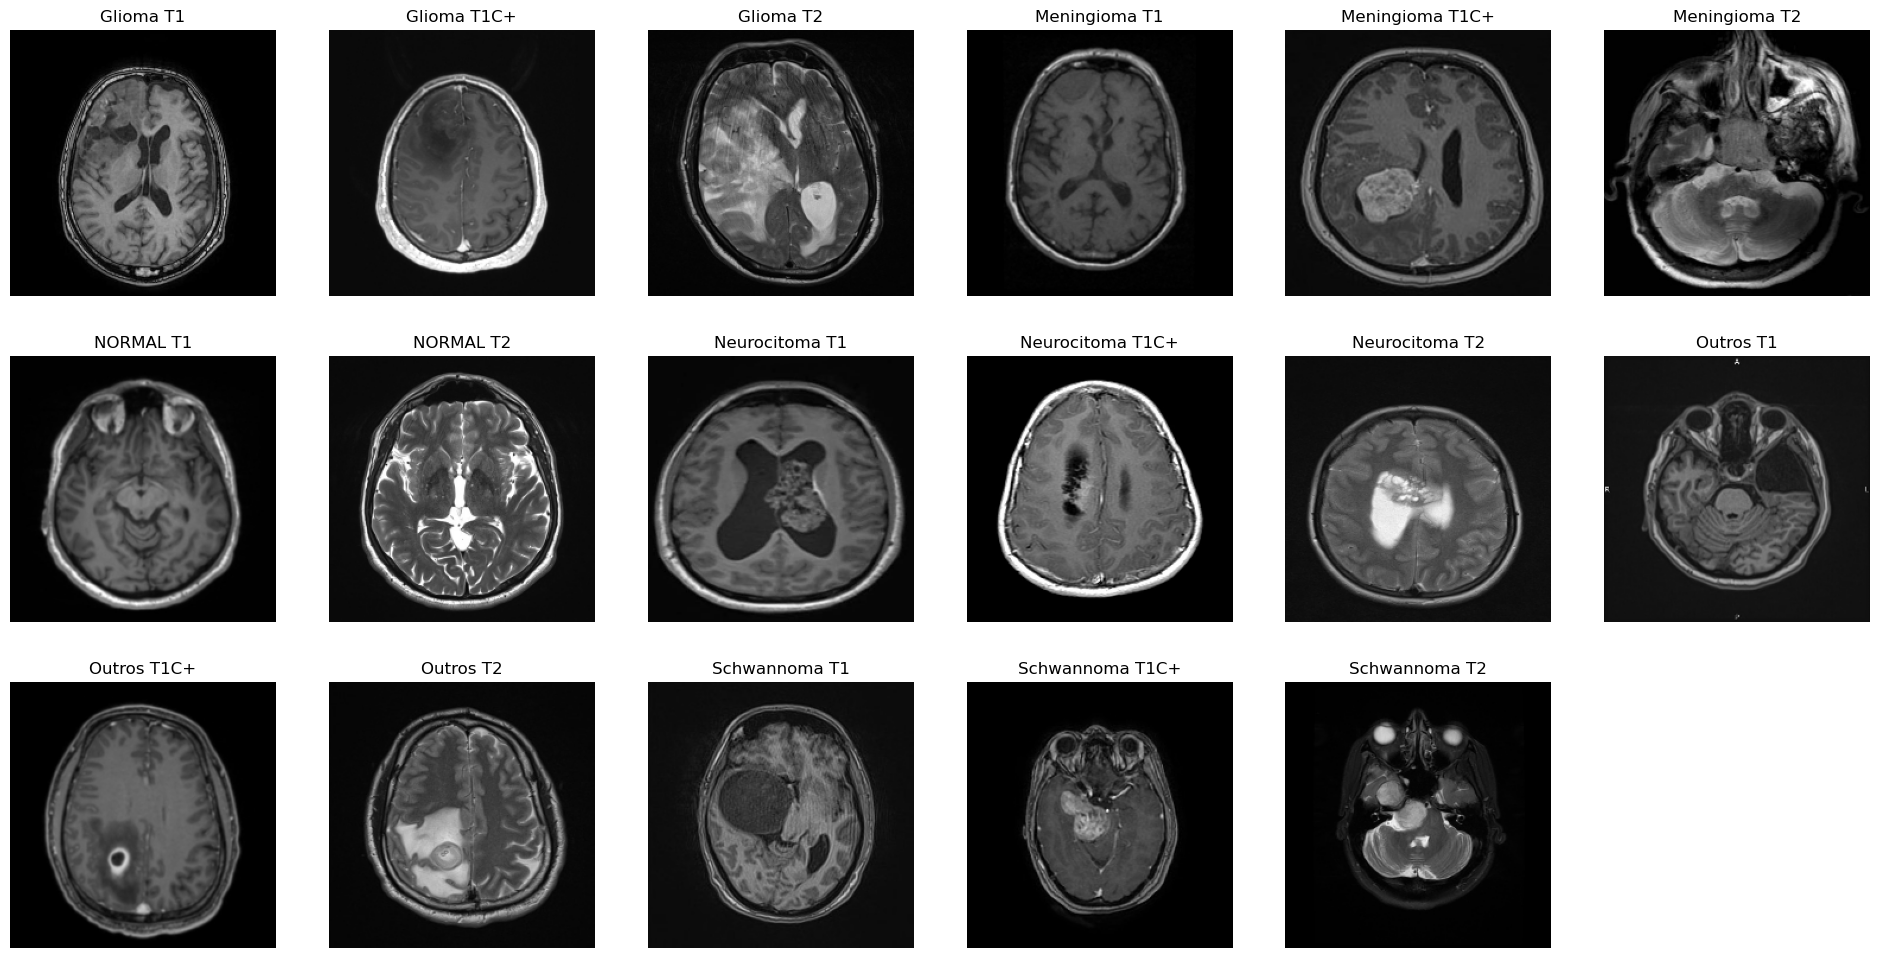

In [53]:
# names of image folders for each class
labels = ['Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1', 
          'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+', 
          'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2', 
          'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1', 
          'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+', 
          'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2', 
          'NORMAL T1',
          'NORMAL T2', 
          'Neurocitoma (Central - Intraventricular, Extraventricular) T1', 
          'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+', 
          'Neurocitoma (Central - Intraventricular, Extraventricular) T2', 
          'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1', 
          'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+', 
          'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2',
          'Schwannoma (Acustico, Vestibular - Trigeminal) T1', 
          'Schwannoma (Acustico, Vestibular - Trigeminal) T1C+', 
          'Schwannoma (Acustico, Vestibular - Trigeminal) T2']

# create shorthand labels for pretty printing and plotting
short_labels = []
for label in labels:
    short_labels.append(label.split(' ')[0] +  ' ' + label.split(' ')[-1])

image_size = 224

plt.figure(figsize=(24, 12))

for i, label in enumerate(labels):
    folderPath = os.path.join('d2/', label)
    img_files = os.listdir(folderPath)
   
    # find a random image for each class
    random_img = random.choice(img_files)
    img_path = os.path.join(folderPath, random_img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (image_size, image_size))

    plt.subplot(3, 6, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    label_words = label.split(' ')
    plt.title(short_labels[i])
    plt.axis('off')

plt.show()


Now, let's take a look at the distribution of image data across the 17 classes in the dataset. Evidently, the dataset has an uneven distribution across classes. There are multiple classes with around 300 images, but the highest (Meningioma T1C+ at around 600) and lowest (Others T1C+ at around 50) differ greatly in number of samples. This difference is most likely representative of the frequency at which each brain tumor class is identified, so we will maintain the inequality in class representation in the dataset. 


[459, 512, 346, 345, 625, 329, 272, 291, 169, 261, 112, 152, 48, 57, 153, 194, 123]


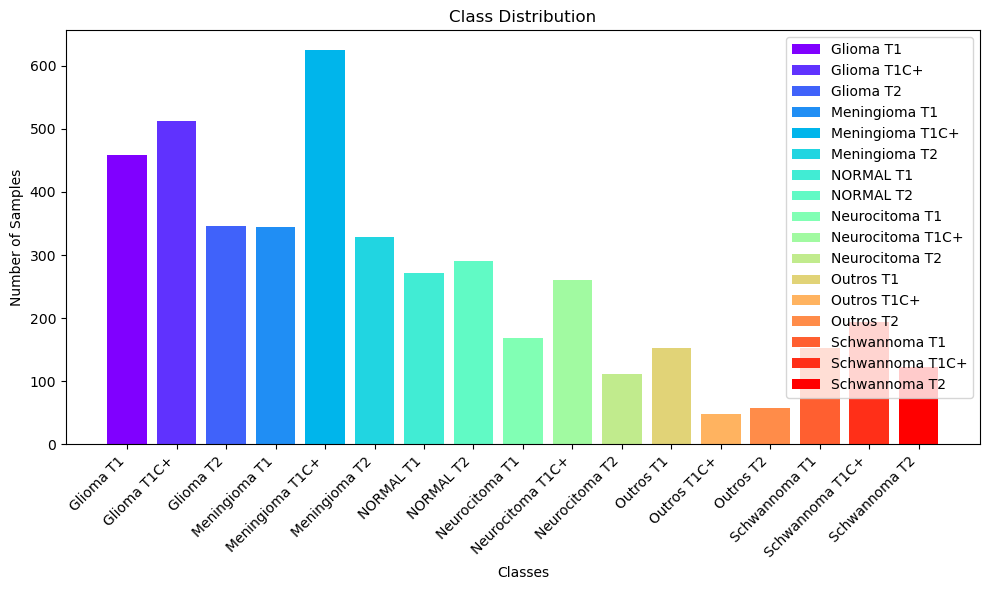

In [115]:
class_counts = [0] * len(dataset2.classes)

# count samples in each class
for _, label in dataset2:
    class_counts[label] += 1
    
print(class_counts)

# make each bar different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(dataset2.classes)))

plt.figure(figsize=(10, 6))
bars = plt.bar(np.arange(len(dataset2.classes)), class_counts, tick_label=short_labels, color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# legend
plt.legend(bars, short_labels, loc='upper right')

plt.show()


Now, since the original dataset is not split into training and testing sets, we will do this manually.


In [133]:
# let's do an 80-20 split for training and testing sets
test_size = len(dataset2)//5
rest_size = len(dataset2) - test_size

# randomly split the data
rest_dataset, test_dataset = random_split(dataset2, [rest_size, test_size])


# let's use 15% of the training set to validate against
validation_ratio = 0.15

# find sizes of training and validation sets
train_size = int((1 - validation_ratio) * rest_size)
val_size = rest_size - train_size

# split randomly
train_dataset, val_dataset = random_split(rest_dataset, [train_size, val_size])

# load up the data
batch_size = 16
trainset_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valset_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
testset_dataloader=DataLoader(test_dataset,batch_size=batch_size)

print("Training set:", train_size, "\nValidation set:", val_size, "\nTest set:", test_size)

Training set: 3025 
Validation set: 534 
Test set: 889


## Testing the "Off-The-Shelf" Method

In the "off-the-shelf" method, we will pass the learned parameters of the final model from Experiment 1, as is, into a new model for the transfer learning problem. We will observe the effectiveness of using the existing model's learned parameters on a similar problem without completing any fine-tuning of the model.

To begin, let's modify the number of output classes of the pre-trained model. For the prior experiment, the desired number of classes was 4, but for this experiment we require 17 distinct class labels. We will retain all of the learned parameters of the model, only replacing the "classification head" representing the number of classes. 

In [134]:
import copy
# make a deep copy of the model to retain the original
pretrained_model = copy.deepcopy(model)

# remove the classification head of the existing model
# We can replace it with a new fully connected layer with the appropriate number of output classes
new_num_classes = len(dataset2.classes)

# Convert LazyLinear to Linear
pretrained_model.fc1 = torch.nn.Linear(pretrained_model.fc1.in_features, pretrained_model.fc1.out_features)

# Replace the final fully connected layer with a new one
new_num_classes = len(dataset2.classes)
pretrained_model.fc2 = torch.nn.Linear(pretrained_model.fc2.in_features, new_num_classes)

print(pretrained_model)

Classifier10(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=17, bias=True)
)


From the printed architecture of the model, we can see that the out_features of fc2 is 17, indicating that there are 17 potential class labels. This satisfies our goal of modifying the model for the new number of classes.

In [135]:
import warnings
# ignore warning about classes with zero predictions
warnings.filterwarnings('ignore')

evaluate_on_test(pretrained_model)

Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.12      0.47      0.19       102
           2       0.00      0.00      0.00        69
           3       0.07      0.05      0.06        75
           4       0.17      0.39      0.24       119
           5       0.00      0.00      0.00        65
           6       0.25      0.02      0.04        49
           7       0.03      0.02      0.02        56
           8       0.00      0.00      0.00        40
           9       0.00      0.00      0.00        50
          10       0.00      0.00      0.00        20
          11       0.09      0.03      0.04        37
          12       0.00      0.00      0.00         8
          13       0.02      0.07      0.03        14
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00        44
          16       0.00      0.00      0.00   

The above classification report shows that the "off-the-shelf" approach for this transfer learning problem very ineffective - the overall accuracy of the new model is 12%. Some of the new classes are being correctly categorized by the new model, but most are not. The two problems at hand are likely not similar enough to utilize the original model to classify images from the second dataset without any fine tuning. Let's try a different approach.

## Testing the "Freeze All Pretrained" Fine-Tuning Method 

In this approach, we will use the same pre-trained model above, which has preserved all the learned parameters from Experiment 1's model 10. This time, before feeding the pre-trained model data from the new dataset, we will train the parameters of the modified output layer on new data. The remaining pre-trained parameters will remain as they are, i.e. "frozen". Finally, we will test the trained model to observe any improvements from the previous iteration.

Epoch [5/5], T Loss: 0.042, V Loss: 0.492, T Precision: 0.990, V Precision: 0.859, T Recall: 0.990, V Recall: 0.854, T F1: 0.990, V F1: 0.853


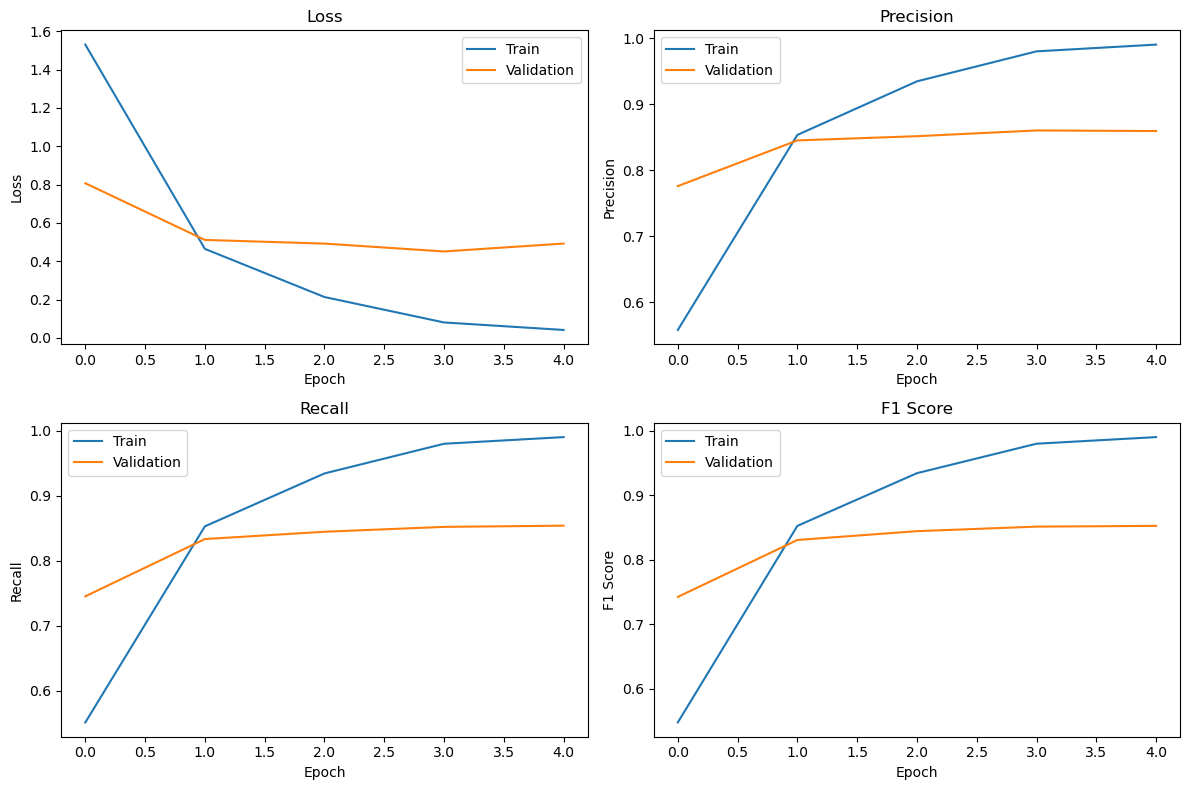

Classification report on test set:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        91
           1       0.95      0.84      0.89       102
           2       0.91      0.74      0.82        69
           3       0.68      0.80      0.74        75
           4       0.90      0.89      0.89       119
           5       0.88      0.82      0.85        65
           6       0.84      0.88      0.86        49
           7       0.82      0.91      0.86        56
           8       0.89      0.85      0.87        40
           9       0.94      0.90      0.92        50
          10       0.79      0.95      0.86        20
          11       1.00      1.00      1.00        37
          12       1.00      0.88      0.93         8
          13       1.00      0.64      0.78        14
          14       0.78      0.82      0.80        22
          15       0.90      1.00      0.95        44
          16       0.82      1.00      0.90   

In [136]:
# make a deep copy of the model to retain the original
freeze_all_model = copy.deepcopy(model)

# Freeze Pre-trained Layers. This makes sure these parameters do not change during training
for param in freeze_all_model.parameters():
    param.requires_grad = False

# remove the classification head of the existing model
# We can replace it with a new fully connected layer with the appropriate number of output classes
new_num_classes = len(dataset2.classes)

# Convert LazyLinear to Linear
freeze_all_model.fc1 = torch.nn.Linear(freeze_all_model.fc1.in_features, freeze_all_model.fc1.out_features)

# Replace the final fully connected layer with a new one
new_num_classes = len(dataset2.classes)
freeze_all_model.fc2 = torch.nn.Linear(freeze_all_model.fc2.in_features, new_num_classes)

# train the model to update the output layer parameters
train(freeze_all_model, epochs=5)
evaluate_on_test(freeze_all_model)    


As shown above in the classification report, this model classifies images from the second dataset much more successfully that the "off-the-shelf" model. By achieving 87% accuracy on the test set, this model has evidently learned more specific details of the MRI images to correctly classify them as one of the new 17 classes. Though this approach was a great improvement from the last, let's try one last method.

## Testing the "Gradual Unfreezing" Fine-Tuning Method

Lastly, we will try a fine-tuning method involving a "gradual unfreezing" of the previously frozen pre-trained layers from Experiment 1. The new output layer of the model begins as the only unfrozen layer in the model. Then, during the training process, the parameters of the next outer-most layers of the model are iteratively unfrozen. This method allows the model more flexibility in learning features that are specific to this classification problem. 

We begin the "unfreezing" process on layers in reverse order. As you move through the layers of the model, the features learned by the corresponding parameters become less broad and less generalizable to similar problems.  The parameters towards the end should be malleable to adapt to the specifics of the new problem. Parameters at the beginning of the model should remain frozen because they capture the broad similarities between the two problems. 

In [113]:
def train_gradually_unfreeze(model, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = epochs

    # store this information for later to calculate metrics
    training_losses, validation_losses = [], []
    training_f1s, validation_f1s = [], []
    training_precisions, validation_precisions = [], []
    training_recalls, validation_recalls = [], []
    
    num_epochs_per_unfreeze = 2  # Number of epochs to train each set of unfrozen layers


    for epoch in range(epochs):
        
        if epoch % num_epochs_per_unfreeze == 0:
            # Unfreeze a few layers every few epochs
            num_layers_to_unfreeze = min((epoch // num_epochs_per_unfreeze) + 1, len(list(model.parameters())))
            # start unfreezing parameters from the later layers of the model first. Doing so will
            # allow the model to learn more specific behavior for the transfer problem
            for param in list(model.parameters())[-num_layers_to_unfreeze:]:
                param.requires_grad = True
            
        # training
        training_predictions, training_labels, cur_train_loss = training_one_epoch(optimizer, model, criterion)

        # validation
        validation_predictions, validation_labels, cur_val_loss = validation_one_epoch(model, criterion)

        # find training scores
        train_f1, train_precision, train_recall, train_epoch_loss = get_metrics(training_labels, training_predictions, cur_train_loss, trainset_dataloader)
        # save training scores
        training_losses.append(train_epoch_loss)
        training_precisions.append(train_precision)
        training_recalls.append(train_recall)
        training_f1s.append(train_f1)

        # find validation scores
        val_f1, val_precision, val_recall, val_epoch_loss = get_metrics(validation_labels, validation_predictions, cur_val_loss, valset_dataloader)
        # save validation scores
        validation_losses.append(val_epoch_loss)
        validation_precisions.append(val_precision)
        validation_recalls.append(val_recall)
        validation_f1s.append(val_f1)
        
        # print info
        
        print(f"Epoch [{epoch+1}/{epochs}], "
            f"T Loss: {train_epoch_loss:.3f}, V Loss: {val_epoch_loss:.3f}, "
            f"T Precision: {train_precision:.3f}, V Precision: {val_precision:.3f}, "
            f"T Recall: {train_recall:.3f}, V Recall: {val_recall:.3f}, "
            f"T F1: {train_f1:.3f}, V F1: {val_f1:.3f}")
        
    # plot all metrics
    plt.figure(figsize=(12, 8))
    plot_metrics("Loss", training_losses, validation_losses, 1)
    plot_metrics("Precision", training_precisions, validation_precisions, 2)
    plot_metrics("Recall", training_recalls, validation_recalls, 3)
    plot_metrics("F1 Score", training_f1s, validation_f1s, 4)
    plt.tight_layout()
    plt.show()

Epoch [1/5], T Loss: 1.525, V Loss: 0.907, T Precision: 0.560, V Precision: 0.736, T Recall: 0.552, V Recall: 0.704, T F1: 0.549, V F1: 0.698
Epoch [2/5], T Loss: 0.396, V Loss: 0.601, T Precision: 0.880, V Precision: 0.833, T Recall: 0.879, V Recall: 0.811, T F1: 0.879, V F1: 0.808
Epoch [3/5], T Loss: 0.167, V Loss: 0.581, T Precision: 0.954, V Precision: 0.838, T Recall: 0.954, V Recall: 0.826, T F1: 0.954, V F1: 0.825
Epoch [4/5], T Loss: 0.107, V Loss: 0.529, T Precision: 0.970, V Precision: 0.847, T Recall: 0.970, V Recall: 0.837, T F1: 0.970, V F1: 0.836
Epoch [5/5], T Loss: 0.066, V Loss: 0.534, T Precision: 0.984, V Precision: 0.862, T Recall: 0.984, V Recall: 0.856, T F1: 0.984, V F1: 0.855


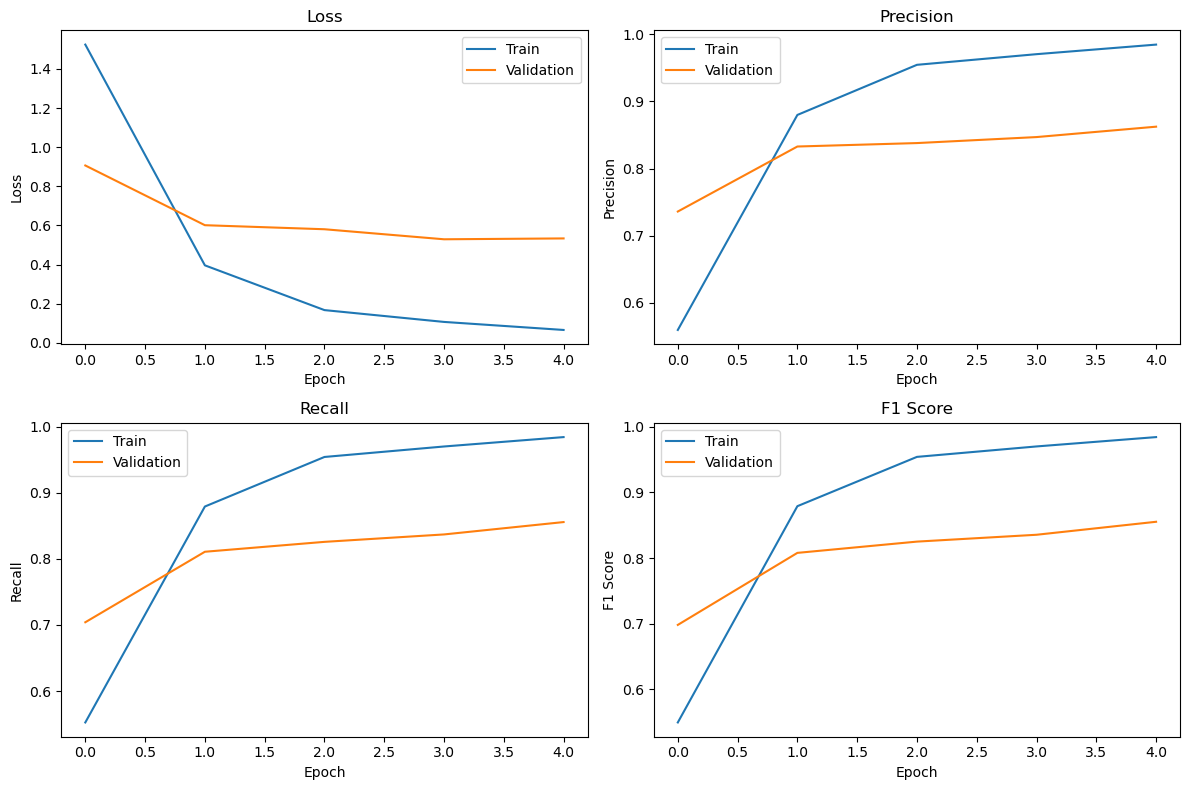

Classification report on test set:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        79
           1       0.97      0.83      0.89       111
           2       0.90      0.78      0.84        83
           3       0.77      0.86      0.81        70
           4       0.82      0.92      0.87       119
           5       0.72      0.83      0.77        63
           6       1.00      0.89      0.94        62
           7       0.91      0.91      0.91        57
           8       0.94      0.78      0.85        37
           9       0.95      0.98      0.97        57
          10       1.00      0.89      0.94        18
          11       0.73      0.95      0.83        20
          12       0.75      1.00      0.86         6
          13       0.71      0.71      0.71        14
          14       0.91      0.91      0.91        33
          15       0.92      0.89      0.90        37
          16       0.96      1.00      0.98   

In [114]:
# make a deep copy of the model to retain the original
gradually_unfreeze_model = copy.deepcopy(model)

# Freeze Pre-trained Layers. These will gradually be unfrozen during training
for param in gradually_unfreeze_model.parameters():
    param.requires_grad = False

# remove the classification head of the existing model
# We can replace it with a new fully connected layer with the appropriate number of output classes
new_num_classes = len(dataset2.classes)

# Convert LazyLinear to Linear
gradually_unfreeze_model.fc1 = torch.nn.Linear(gradually_unfreeze_model.fc1.in_features, gradually_unfreeze_model.fc1.out_features)

# Replace the final fully connected layer with a new one
new_num_classes = len(dataset2.classes)
gradually_unfreeze_model.fc2 = torch.nn.Linear(gradually_unfreeze_model.fc2.in_features, new_num_classes)

# train the model to update the output layer parameters and gradually start to update inner layer parameters
train_gradually_unfreeze(gradually_unfreeze_model, epochs=5)
evaluate_on_test(gradually_unfreeze_model)   

Unexpectedly, there was no noticeable improvement in model performance after utilizing gradual unfreezing. Of course, tuning of hyperparameters such as number of epochs, how frequently to unfreeze layers, etc. can change the performance of the model.  

## Experiment 2 Results

In order to use the final model trained in Experiment 1 for a new classification problem with a second dataset, it was most effective to utilize a fine-tuning approach, rather than using the model's learned parameters "off-the-shelf". By freezing the pre-trained paramaters from the original model and training on just the classification head (i.e. linear output layer), the augmented model was able to reach an accuracy of 87%. Performing gradual unfreezing of the outermost layers' parameters, intended to allow further flexibility to train on the new task, also enabled the new model to reach an accuracy of 87%. Thus, the two latter methods used to fine-tune the original model were equally successful in solving this adjacent problem of a 17-class brain tumor classification.